<a href="https://colab.research.google.com/github/macscheffer/DS-Unit-2-Sprint-2-Linear-Regression/blob/master/module2-polynomial-regression/Polynomial_Log_linear_Regression_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intermediate Linear Regression Practice

## Use a Linear Regression model to get the lowest RMSE possible on the following dataset:

[Dataset Folder](https://github.com/ryanleeallred/datasets/tree/master/Ames%20Housing%20Data)

[Raw CSV](https://raw.githubusercontent.com/ryanleeallred/datasets/master/Ames%20Housing%20Data/train.csv)

## You model must include (at least):
- A log-transformed y variable
- Two polynomial features
- One interaction feature
- 10 other engineered features

What is the lowest Root-Mean-Squared Error that you are able to obtain? Share your best RMSEs in Slack!

Notes:

There may be some data cleaning that you need to do on some features of this dataset. Linear Regression will only accept numeric values and will not accept

Note* There may not be a clear candidate for an interaction term in this dataset. Include one anyway, sometimes it's a good practice for predictive modeling feature engineering in general. 

In [1]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/ryanleeallred/datasets/master/Ames%20Housing%20Data/train.csv')

df.shape

(1460, 81)

In [24]:
df[df.PoolArea > 0].SalePrice.mean()

288138.5714285714

In [0]:
df['matching_exterior_type'] = (df.Exterior1st == df.Exterior2nd)

In [46]:
df.pivot_table(index='matching_exterior_type', values='SalePrice')

,SalePrice
matching_exterior_type,
False,182820.093023
True,180593.273896


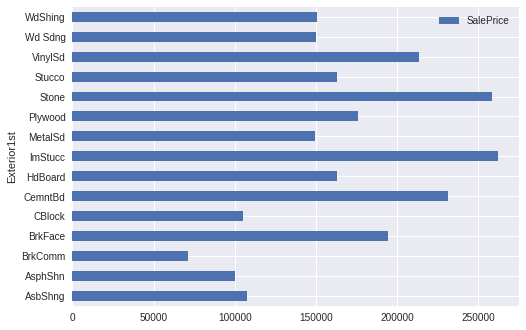

In [49]:
df.pivot_table(index='Exterior1st',values='SalePrice').plot.barh()

In [50]:
df.Street.value_counts()

Pave    1454
Grvl       6
Name: Street, dtype: int64

In [52]:
df.pivot_table(index='Street', values='SalePrice')

,SalePrice
Street,
Grvl,130190.500000
Pave,181130.538514


In [8]:
df.SalePrice.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [16]:
df[df.SalePrice > 250000].shape[0] / df.shape[0]

0.14863013698630137

In [17]:
df[df.SalePrice < 110000].shape[0] / df.shape[0]

0.11986301369863013

In [20]:
df.SaleCondition.value_counts()

Normal     1198
Partial     125
Abnorml     101
Family       20
Alloca       12
AdjLand       4
Name: SaleCondition, dtype: int64

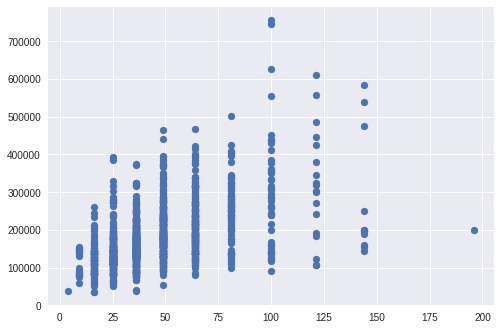

In [40]:
import matplotlib.pyplot as plt
import numpy as np

plt.scatter(df.TotRmsAbvGrd**2,df.SalePrice)

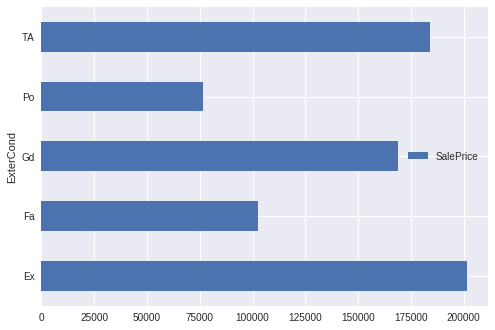

In [41]:
df.pivot_table(index='ExterCond', values='SalePrice').plot.barh()

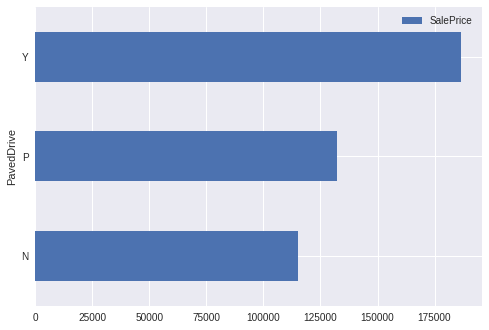

In [25]:
df.pivot_table(index='PavedDrive', values='SalePrice').plot.barh()

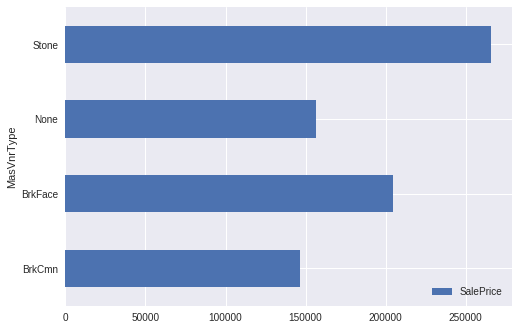

In [43]:
df.pivot_table(index='MasVnrType', values='SalePrice').plot.barh()

In [44]:
df.MasVnrType.value_counts()

None       864
BrkFace    445
Stone      128
BrkCmn      15
Name: MasVnrType, dtype: int64

In [42]:
df.ExterCond.value_counts()

TA    1282
Gd     146
Fa      28
Ex       3
Po       1
Name: ExterCond, dtype: int64

In [31]:
df.Foundation.value_counts()

PConc     647
CBlock    634
BrkTil    146
Slab       24
Stone       6
Wood        3
Name: Foundation, dtype: int64

In [30]:
df.GarageFinish.value_counts()

Unf    605
RFn    422
Fin    352
Name: GarageFinish, dtype: int64

In [26]:
df.PavedDrive.value_counts()

Y    1340
N      90
P      30
Name: PavedDrive, dtype: int64

In [35]:
df.Electrical.value_counts()

SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

In [36]:
df.pivot_table(index='Electrical', values='SalePrice')

,SalePrice
Electrical,
FuseA,122196.893617
FuseF,107675.444444
FuseP,97333.333333
Mix,67000.000000
SBrkr,186825.113193


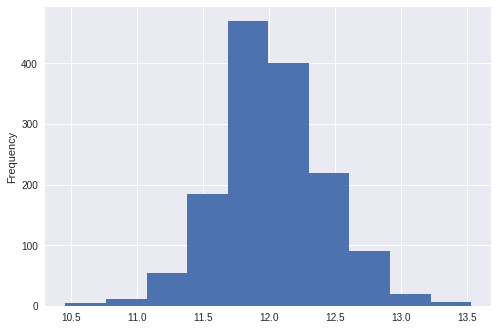

In [53]:
import numpy as np

np.log(df.SalePrice).plot.hist()

In [0]:
df['logprice'] = np.log(df.SalePrice)

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt

X = df.loc[:, ['LotArea']].values
y = df.loc[:,['logprice']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)


lr = LinearRegression()
lr.fit(X_train, y_train)


oos_pred = lr.predict(X_test)
oos_mse = mean_squared_error(y_test, oos_pred)
oos_r2 = r2_score(y_test, oos_pred)
rmse = (np.sqrt(oos_mse))

In [56]:
pd.set_option('display.max_columns', 500)
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,matching_exterior_type,logprice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500,True,12.247694
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500,True,12.109011
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500,True,12.317167
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000,False,11.849398
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000,True,12.429216


In [57]:
features = ['LotArea', 'OverallQual']
X = df[features].values
y = df.loc[:,['logprice']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


lr = LinearRegression()
lr.fit(X_train, y_train)


oos_pred = lr.predict(X_test)
oos_mse = mean_squared_error(y_test, oos_pred)
oos_r2 = r2_score(y_test, oos_pred)
rmse = (np.sqrt(oos_mse))
rmse

0.219812430665842

In [58]:
features = ['LotArea', 'OverallQual', 'OverallCond', 'GrLivArea','GarageArea', 'GarageCars']
X = df[features].values
y = df.loc[:,['logprice']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


lr = LinearRegression()
lr.fit(X_train, y_train)


oos_pred = lr.predict(X_test)
oos_mse = mean_squared_error(y_test, oos_pred)
oos_r2 = r2_score(y_test, oos_pred)
rmse = (np.sqrt(oos_mse))
rmse

0.18045001504174427

In [59]:
features = ['LotArea', 'OverallQual', 'OverallCond', 'GrLivArea','GarageArea', 'GarageCars', 'FullBath', 'HalfBath']
X = df[features].values
y = df.loc[:,['logprice']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


lr = LinearRegression()
lr.fit(X_train, y_train)


oos_pred = lr.predict(X_test)
oos_mse = mean_squared_error(y_test, oos_pred)
oos_r2 = r2_score(y_test, oos_pred)
rmse = (np.sqrt(oos_mse))
rmse

0.17990333103566045

In [0]:
df['fullhalfbath_interaction'] = df.FullBath * df.HalfBath

In [61]:
features = ['LotArea', 'OverallQual', 'OverallCond', 'GrLivArea','GarageArea', 'GarageCars', 'FullBath', 'HalfBath', 'fullhalfbath_interaction']
X = df[features].values
y = df.loc[:,['logprice']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


lr = LinearRegression()
lr.fit(X_train, y_train)


oos_pred = lr.predict(X_test)
oos_mse = mean_squared_error(y_test, oos_pred)
oos_r2 = r2_score(y_test, oos_pred)
rmse = (np.sqrt(oos_mse))
rmse

0.17941350562118014

In [64]:
features = ['LotArea', 'OverallQual', 'OverallCond', 'GrLivArea','GarageArea', 'GarageCars', 'FullBath', 'HalfBath', 'fullhalfbath_interaction', 'BedroomAbvGr']
X = df[features].values
y = df.loc[:,['logprice']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


lr = LinearRegression()
lr.fit(X_train, y_train)


oos_pred = lr.predict(X_test)
oos_mse = mean_squared_error(y_test, oos_pred)
oos_r2 = r2_score(y_test, oos_pred)
rmse = (np.sqrt(oos_mse))
rmse

0.17876742238505144

In [65]:
df.pivot_table(index='YrSold', values='SalePrice')

,SalePrice
YrSold,
2006,182549.458599
2007,186063.151976
2008,177360.838816
2009,179432.103550
2010,177393.674286


In [66]:
df.YrSold.value_counts()

2009    338
2007    329
2006    314
2008    304
2010    175
Name: YrSold, dtype: int64

In [0]:
df['sold_pre_2008'] = (df.YrSold < 2008)

In [68]:
features = ['LotArea', 'OverallQual', 'OverallCond', 'GrLivArea','GarageArea', 'GarageCars', 'FullBath', 'HalfBath', 'fullhalfbath_interaction', 'BedroomAbvGr',
            'sold_pre_2008']
X = df[features].values
y = df.loc[:,['logprice']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


lr = LinearRegression()
lr.fit(X_train, y_train)


oos_pred = lr.predict(X_test)
oos_mse = mean_squared_error(y_test, oos_pred)
oos_r2 = r2_score(y_test, oos_pred)
rmse = (np.sqrt(oos_mse))
rmse

0.17857500842915905

In [0]:
df['age_sold'] = df.YrSold - df.YearBuilt
df['age_sold_squared'] = df.age_sold ** 2

In [86]:
features = ['LotArea', 'OverallQual', 'OverallCond', 'GrLivArea','GarageArea', 'GarageCars', 'FullBath', 'HalfBath', 'fullhalfbath_interaction', 'BedroomAbvGr',
            'sold_pre_2008', 'age_sold', 'age_sold_squared']
X = df[features].values
y = df.loc[:,['logprice']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


lr = LinearRegression()
lr.fit(X_train, y_train)


oos_pred = lr.predict(X_test)
oos_mse = mean_squared_error(y_test, oos_pred)
oos_r2 = r2_score(y_test, oos_pred)
rmse = (np.sqrt(oos_mse))
rmse

0.16114651181543724

In [0]:
df['years_since_remod'] = df.YrSold - df.YearRemodAdd
df['years_since_remod_squared'] = df.YrSold - df.YearRemodAdd

In [92]:
features = ['LotArea', 'OverallQual', 'OverallCond', 'GrLivArea','GarageArea', 'GarageCars', 'FullBath', 'HalfBath', 'fullhalfbath_interaction', 'BedroomAbvGr',
            'sold_pre_2008', 'age_sold', 'age_sold_squared', 'years_since_remod', 'years_since_remod_squared']
X = df[features].values
y = df.loc[:,['logprice']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


lr = LinearRegression()
lr.fit(X_train, y_train)


oos_pred = lr.predict(X_test)
oos_mse = mean_squared_error(y_test, oos_pred)
oos_r2 = r2_score(y_test, oos_pred)
rmse = (np.sqrt(oos_mse))
rmse

0.16162938032681207

In [0]:
df['age_remod_interaction'] = df.age_sold * df.years_since_remod
df['age_remod_interaction_squared'] = df.age_sold_squared * df.years_since_remod_squared

In [96]:
features = ['LotArea', 'OverallQual', 'OverallCond', 'GrLivArea','GarageArea', 'GarageCars', 'FullBath', 'HalfBath', 'fullhalfbath_interaction', 'BedroomAbvGr',
            'sold_pre_2008', 'age_sold', 'years_since_remod', 'age_remod_interaction', 'years_since_remod_squared', 'age_sold_squared', 'age_remod_interaction_squared']
X = df[features].values
y = df.loc[:,['logprice']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


lr = LinearRegression()
lr.fit(X_train, y_train)


oos_pred = lr.predict(X_test)
oos_mse = mean_squared_error(y_test, oos_pred)
oos_r2 = r2_score(y_test, oos_pred)
rmse = (np.sqrt(oos_mse))
rmse

0.1616454002308544

In [97]:
features = ['LotArea', 'OverallQual', 'OverallCond', 'GrLivArea','GarageArea', 'GarageCars', 'FullBath', 'HalfBath', 'fullhalfbath_interaction', 'BedroomAbvGr',
            'sold_pre_2008', 'age_sold', 'years_since_remod', 'age_remod_interaction', '1stFlrSF', '2ndFlrSF']
X = df[features].values
y = df.loc[:,['logprice']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


lr = LinearRegression()
lr.fit(X_train, y_train)


oos_pred = lr.predict(X_test)
oos_mse = mean_squared_error(y_test, oos_pred)
oos_r2 = r2_score(y_test, oos_pred)
rmse = (np.sqrt(oos_mse))
rmse

0.15511110951231402

In [0]:
df['floor_interaction'] = df['1stFlrSF'] * df['2ndFlrSF']

In [99]:
features = ['LotArea', 'OverallQual', 'OverallCond', 'GrLivArea','GarageArea', 'GarageCars', 'FullBath', 'HalfBath', 'fullhalfbath_interaction', 'BedroomAbvGr',
            'sold_pre_2008', 'age_sold', 'years_since_remod', 'age_remod_interaction', '1stFlrSF', '2ndFlrSF', 'floor_interaction']
X = df[features].values
y = df.loc[:,['logprice']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


lr = LinearRegression()
lr.fit(X_train, y_train)


oos_pred = lr.predict(X_test)
oos_mse = mean_squared_error(y_test, oos_pred)
oos_r2 = r2_score(y_test, oos_pred)
rmse = (np.sqrt(oos_mse))
rmse

0.1548967916031227

In [0]:
df['mszoning_RL'] = (df.MSZoning == 'RL')
df['mszoning_c'] = (df.MSZoning == 'C (all)')
df['mszoning_RM'] = (df.MSZoning == 'RM')
df['mszoning_FV'] = (df.MSZoning == 'FV')

In [103]:
features = ['LotArea', 'OverallQual', 'OverallCond', 'GrLivArea','GarageArea', 'GarageCars', 'FullBath', 'HalfBath', 'fullhalfbath_interaction', 'BedroomAbvGr',
            'sold_pre_2008', 'age_sold', 'years_since_remod', 'age_remod_interaction', '1stFlrSF', '2ndFlrSF', 'floor_interaction', 'mszoning_RL', 'mszoning_c',
            'mszoning_RM', 'mszoning_FV']
X = df[features].values
y = df.loc[:,['logprice']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


lr = LinearRegression()
lr.fit(X_train, y_train)


oos_pred = lr.predict(X_test)
oos_mse = mean_squared_error(y_test, oos_pred)
oos_r2 = r2_score(y_test, oos_pred)
rmse = (np.sqrt(oos_mse))
rmse

0.14361104119158047

In [0]:
df['good_area'] = ((df.Neighborhood == 'NoRidge') | (df.Neighborhood == 'NridgeHt') | (df.Neighborhood == 'StoneBr'))
df['bad_area'] = ((df.Neighborhood == 'MeadowV') | (df.Neighborhood == 'IDOTRR') | (df.Neighborhood == 'BrDale'))

In [105]:
features = ['LotArea', 'OverallQual', 'OverallCond', 'GrLivArea','GarageArea', 'GarageCars', 'FullBath', 'HalfBath', 'fullhalfbath_interaction', 'BedroomAbvGr',
            'sold_pre_2008', 'age_sold', 'years_since_remod', 'age_remod_interaction', '1stFlrSF', '2ndFlrSF', 'floor_interaction', 'mszoning_RL', 'mszoning_c',
            'mszoning_RM', 'mszoning_FV', 'good_area', 'bad_area']
X = df[features].values
y = df.loc[:,['logprice']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


lr = LinearRegression()
lr.fit(X_train, y_train)


oos_pred = lr.predict(X_test)
oos_mse = mean_squared_error(y_test, oos_pred)
oos_r2 = r2_score(y_test, oos_pred)
rmse = (np.sqrt(oos_mse))
rmse

0.14186182624711163

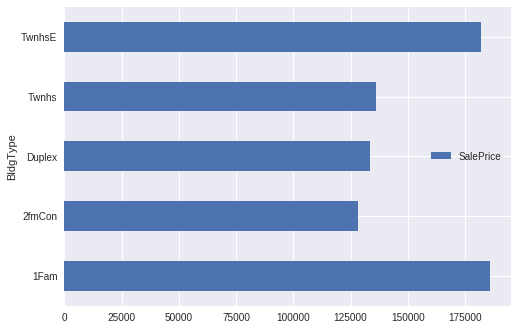

In [106]:
df.pivot_table(index='BldgType', values='SalePrice').plot.barh()

In [107]:
df.BldgType.value_counts()

1Fam      1220
TwnhsE     114
Duplex      52
Twnhs       43
2fmCon      31
Name: BldgType, dtype: int64

In [0]:
df['one_fam_home'] = (df.BldgType == '1Fam')
df['townhouse'] = (df.BldgType == 'TwnhsE')

In [110]:
features = ['LotArea', 'OverallQual', 'OverallCond', 'GrLivArea','GarageArea', 'GarageCars', 'FullBath', 'HalfBath', 'fullhalfbath_interaction', 'BedroomAbvGr',
            'sold_pre_2008', 'age_sold', 'age_sold_squared', '1stFlrSF', '2ndFlrSF', 'floor_interaction', 'mszoning_RL', 'mszoning_c',
            'mszoning_RM', 'mszoning_FV', 'good_area', 'bad_area', 'one_fam_home', 'townhouse']
X = df[features].values
y = df.loc[:,['logprice']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


lr = LinearRegression()
lr.fit(X_train, y_train)


oos_pred = lr.predict(X_test)
oos_mse = mean_squared_error(y_test, oos_pred)
oos_r2 = r2_score(y_test, oos_pred)
rmse = (np.sqrt(oos_mse))
rmse

0.14079685931357241

In [111]:
df.MiscFeature.value_counts()

Shed    49
Othr     2
Gar2     2
TenC     1
Name: MiscFeature, dtype: int64

In [0]:
df.MiscFeature = df.MiscFeature.fillna('None')

In [0]:
df['miscfeature_isnone'] = (df.MiscFeature == 'None')
df['has_shed'] = (df.MiscFeature == 'Shed')

In [115]:
features = ['LotArea', 'OverallQual', 'OverallCond', 'GrLivArea','GarageArea', 'GarageCars', 'FullBath', 'HalfBath', 'fullhalfbath_interaction', 'BedroomAbvGr',
            'sold_pre_2008', 'age_sold', 'age_sold_squared', '1stFlrSF', '2ndFlrSF', 'floor_interaction', 'mszoning_RL', 'mszoning_c',
            'mszoning_RM', 'mszoning_FV', 'good_area', 'bad_area', 'one_fam_home', 'townhouse', 'miscfeature_isnone']
X = df[features].values
y = df.loc[:,['logprice']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


lr = LinearRegression()
lr.fit(X_train, y_train)


oos_pred = lr.predict(X_test)
oos_mse = mean_squared_error(y_test, oos_pred)
oos_r2 = r2_score(y_test, oos_pred)
rmse = (np.sqrt(oos_mse))
rmse

0.1406222601032142

In [116]:
df.SaleType.value_counts()

WD       1267
New       122
COD        43
ConLD       9
ConLw       5
ConLI       5
CWD         4
Oth         3
Con         2
Name: SaleType, dtype: int64

In [0]:
df['new_home'] = (df.SaleType == 'New')
df['saletype_cod'] = (df.SaleType == 'COD')
df['saletype_lowdn_lowint'] = ((df.SaleType == 'ConLD') | (df.SaleType == 'ConLw'))

In [121]:
features = ['LotArea', 'OverallQual', 'OverallCond', 'GrLivArea','GarageArea', 'GarageCars', 'FullBath', 'HalfBath', 'fullhalfbath_interaction', 'BedroomAbvGr',
            'sold_pre_2008', 'age_sold', 'age_sold_squared', '1stFlrSF', '2ndFlrSF', 'floor_interaction', 'mszoning_RL', 'mszoning_c',
            'mszoning_RM', 'mszoning_FV', 'good_area', 'bad_area', 'one_fam_home', 'townhouse', 'miscfeature_isnone', 'has_shed', 'new_home', 'saletype_lowdn_lowint',
            'saletype_cod']
X = df[features].values
y = df.loc[:,['logprice']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


lr = LinearRegression()
lr.fit(X_train, y_train)


oos_pred = lr.predict(X_test)
oos_mse = mean_squared_error(y_test, oos_pred)
oos_r2 = r2_score(y_test, oos_pred)
rmse = (np.sqrt(oos_mse))
rmse

0.1400335528866995

In [0]:
df['attached_garage'] = (df.GarageType == 'Attchd')
df['detchd_garage'] = (df.GarageType == 'Detchd')

In [124]:
features = ['LotArea', 'OverallQual', 'OverallCond', 'GrLivArea','GarageArea', 'GarageCars', 'FullBath', 'HalfBath', 'fullhalfbath_interaction', 'BedroomAbvGr',
            'sold_pre_2008', 'age_sold', 'age_sold_squared', '1stFlrSF', '2ndFlrSF', 'floor_interaction', 'mszoning_RL', 'mszoning_c',
            'mszoning_RM', 'mszoning_FV', 'good_area', 'bad_area', 'one_fam_home', 'townhouse', 'miscfeature_isnone', 'has_shed', 'new_home', 'saletype_lowdn_lowint',
            'saletype_cod', 'attached_garage', 'detchd_garage']
X = df[features].values
y = df.loc[:,['logprice']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


lr = LinearRegression()
lr.fit(X_train, y_train)


oos_pred = lr.predict(X_test)
oos_mse = mean_squared_error(y_test, oos_pred)
oos_r2 = r2_score(y_test, oos_pred)
rmse = (np.sqrt(oos_mse))
rmse

0.13995145968023726

In [0]:
df['lotarea_squared'] = df.LotArea ** 2
df['overallqual_squared'] = df.OverallQual ** 2
df['overallcond_squared'] = df.OverallCond ** 2


In [127]:
features = ['LotArea', 'OverallQual', 'OverallCond', 'GrLivArea','GarageArea', 'GarageCars', 'FullBath', 'HalfBath', 'fullhalfbath_interaction', 'BedroomAbvGr',
            'sold_pre_2008', 'age_sold', 'age_sold_squared', '1stFlrSF', '2ndFlrSF', 'floor_interaction', 'mszoning_RL', 'mszoning_c',
            'mszoning_RM', 'mszoning_FV', 'good_area', 'bad_area', 'one_fam_home', 'townhouse', 'miscfeature_isnone', 'has_shed', 'new_home', 'saletype_lowdn_lowint',
            'saletype_cod', 'attached_garage', 'detchd_garage', 'lotarea_squared', 'overallqual_squared', 'overallcond_squared']

X = df[features].values
y = df.loc[:,['logprice']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


lr = LinearRegression()
lr.fit(X_train, y_train)


oos_pred = lr.predict(X_test)
oos_mse = mean_squared_error(y_test, oos_pred)
oos_r2 = r2_score(y_test, oos_pred)
rmse = (np.sqrt(oos_mse))
rmse

0.13867660428394862

In [0]:
df['is_start_of_school'] = (df.MoSold == 9)
df['is_spring'] = ((df.MoSold == 4) | (df.MoSold == 5))

In [129]:
features = ['LotArea', 'OverallQual', 'OverallCond', 'GrLivArea','GarageArea', 'GarageCars', 'FullBath', 'HalfBath', 'fullhalfbath_interaction', 'BedroomAbvGr',
            'sold_pre_2008', 'age_sold', 'years_since_remod', 'age_remod_interaction', '1stFlrSF', '2ndFlrSF', 'floor_interaction', 'mszoning_RL', 'mszoning_c',
            'mszoning_RM', 'mszoning_FV', 'good_area', 'bad_area', 'one_fam_home', 'townhouse', 'miscfeature_isnone', 'has_shed', 'new_home', 'attached_garage',
            'detchd_garage', 'lotarea_squared', 'overallqual_squared', 'overallcond_squared', 'is_start_of_school', 'is_spring']

X = df[features].values
y = df.loc[:,['logprice']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


lr = LinearRegression()
lr.fit(X_train, y_train)


oos_pred = lr.predict(X_test)
oos_mse = mean_squared_error(y_test, oos_pred)
oos_r2 = r2_score(y_test, oos_pred)
rmse = (np.sqrt(oos_mse))
rmse

0.13965680003416253

In [0]:
df['remodeled?'] = (df.YearBuilt != df.YearRemodAdd)

In [134]:
features = ['LotArea', 'OverallQual', 'OverallCond', 'GrLivArea','GarageArea', 'GarageCars', 'FullBath', 'HalfBath', 'fullhalfbath_interaction', 'BedroomAbvGr',
            'sold_pre_2008', 'age_sold', 'years_since_remod', 'age_remod_interaction', '1stFlrSF', '2ndFlrSF', 'floor_interaction', 'mszoning_RL', 'mszoning_c',
            'mszoning_RM', 'mszoning_FV', 'good_area', 'bad_area', 'one_fam_home', 'townhouse', 'miscfeature_isnone', 'has_shed', 'new_home', 'attached_garage',
            'detchd_garage', 'lotarea_squared', 'overallqual_squared', 'overallcond_squared', 'is_start_of_school', 'is_spring', 'remodeled?']

X = df[features].values
y = df.loc[:,['logprice']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


lr = LinearRegression()
lr.fit(X_train, y_train)


oos_pred = lr.predict(X_test)
oos_mse = mean_squared_error(y_test, oos_pred)
oos_r2 = r2_score(y_test, oos_pred)
rmse = (np.sqrt(oos_mse))
rmse

0.1397498301197803

In [0]:
df['age_remodeled_interaction_good'] = (df.age_sold * df['remodeled?']) 

In [136]:
features = ['LotArea', 'OverallQual', 'OverallCond', 'GrLivArea','GarageArea', 'GarageCars', 'FullBath', 'HalfBath', 'fullhalfbath_interaction', 'BedroomAbvGr',
            'sold_pre_2008', 'age_sold', 'years_since_remod', 'age_remod_interaction', '1stFlrSF', '2ndFlrSF', 'floor_interaction', 'mszoning_RL', 'mszoning_c',
            'mszoning_RM', 'mszoning_FV', 'good_area', 'bad_area', 'one_fam_home', 'townhouse', 'miscfeature_isnone', 'has_shed', 'new_home', 'attached_garage',
            'detchd_garage', 'lotarea_squared', 'overallqual_squared', 'overallcond_squared', 'is_start_of_school', 'is_spring', 'remodeled?', 'age_remodeled_interaction_good']

X = df[features].values
y = df.loc[:,['logprice']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


lr = LinearRegression()
lr.fit(X_train, y_train)


oos_pred = lr.predict(X_test)
oos_mse = mean_squared_error(y_test, oos_pred)
oos_r2 = r2_score(y_test, oos_pred)
rmse = (np.sqrt(oos_mse))
rmse, oos_r2

(0.13951684598359806, 0.8875894154193711)

In [0]:
df['sq_footage_fsb'] = df['1stFlrSF'] + df['2ndFlrSF'] + df.BsmtFinSF1
df['sqfootage_fsb_squared'] = df.sq_footage_fsb ** 2

In [142]:
features = ['LotArea', 'OverallQual', 'OverallCond', 'GrLivArea','GarageArea', 'GarageCars', 'FullBath', 'HalfBath', 'fullhalfbath_interaction', 'BedroomAbvGr',
            'sold_pre_2008', 'age_sold', 'age_sold_squared', 'years_since_remod', 'age_remod_interaction', '1stFlrSF', '2ndFlrSF', 'floor_interaction', 'mszoning_RL', 'mszoning_c',
            'mszoning_RM', 'mszoning_FV', 'good_area', 'bad_area', 'one_fam_home', 'townhouse', 'miscfeature_isnone', 'has_shed', 'new_home', 'attached_garage',
            'detchd_garage', 'lotarea_squared', 'overallqual_squared', 'overallcond_squared', 'is_start_of_school', 'is_spring', 'remodeled?', 'age_remodeled_interaction_good',
            'sq_footage_fsb', 'sqfootage_fsb_squared']

X = df[features].values
y = df.loc[:,['logprice']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


lr = LinearRegression()
lr.fit(X_train, y_train)


oos_pred = lr.predict(X_test)
oos_mse = mean_squared_error(y_test, oos_pred)
oos_r2 = r2_score(y_test, oos_pred)
rmse = (np.sqrt(oos_mse))
rmse, oos_r2

(0.12416043117731722, 0.9109732885955805)

In [0]:
df['fullbath_squared'] = df.FullBath ** 2
df['grlivarea_squared'] = df.GrLivArea ** 2

In [149]:
features = ['LotArea', 'OverallQual', 'OverallCond', 'GrLivArea','GarageArea', 'GarageCars', 'FullBath', 'HalfBath', 'fullhalfbath_interaction', 'BedroomAbvGr',
            'sold_pre_2008', 'age_sold','age_sold_squared', 'years_since_remod', 'age_remod_interaction', '1stFlrSF', '2ndFlrSF', 'floor_interaction', 'mszoning_RL', 'mszoning_c',
            'mszoning_RM', 'mszoning_FV', 'good_area', 'bad_area', 'one_fam_home', 'townhouse', 'miscfeature_isnone', 'has_shed', 'new_home', 'attached_garage',
            'detchd_garage', 'lotarea_squared', 'overallqual_squared', 'overallcond_squared', 'is_start_of_school', 'is_spring', 'remodeled?', 'age_remodeled_interaction_good',
            'sq_footage_fsb', 'sqfootage_fsb_squared', 'grlivarea_squared']

X = df[features].values
y = df.loc[:,['logprice']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


lr = LinearRegression()
lr.fit(X_train, y_train)


oos_pred = lr.predict(X_test)
oos_mse = mean_squared_error(y_test, oos_pred)
oos_r2 = r2_score(y_test, oos_pred)
rmse = (np.sqrt(oos_mse))
rmse, oos_r2

(0.12372682436024579, 0.9115940206997053)

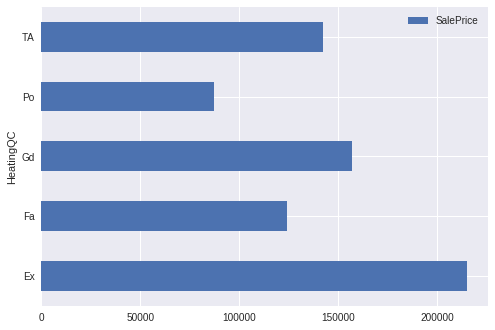

In [154]:
df.pivot_table(index='HeatingQC', values='SalePrice').plot.barh()

In [153]:
df.HeatingQC.value_counts()

Ex    741
TA    428
Gd    241
Fa     49
Po      1
Name: HeatingQC, dtype: int64

In [0]:
df['heating_gasa'] = (df.Heating == 'GasA')
df['heating_qual_ex'] = (df.HeatingQC == 'Ex')
df['heating_qual_pr'] = (df.HeatingQC == 'Po')
df['heating_qual_fa'] = (df.HeatingQC == 'Fa')

In [165]:
features = ['LotArea', 'OverallQual', 'OverallCond', 'GrLivArea','GarageArea', 'GarageCars', 'FullBath', 'HalfBath', 'fullhalfbath_interaction', 'BedroomAbvGr',
            'sold_pre_2008', 'age_sold','age_sold_squared', 'years_since_remod', 'age_remod_interaction', '1stFlrSF', '2ndFlrSF', 'floor_interaction', 'mszoning_RL', 'mszoning_c',
            'mszoning_RM', 'mszoning_FV', 'good_area', 'bad_area', 'one_fam_home', 'townhouse', 'miscfeature_isnone', 'has_shed', 'new_home', 'attached_garage',
            'detchd_garage', 'lotarea_squared', 'overallqual_squared', 'overallcond_squared', 'is_start_of_school', 'is_spring', 'remodeled?', 'age_remodeled_interaction_good',
            'sq_footage_fsb', 'sqfootage_fsb_squared', 'grlivarea_squared', 'heating_qual_ex', 'heating_qual_pr', 'heating_qual_fa']

X = df[features].values
y = df.loc[:,['logprice']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


lr = LinearRegression()
lr.fit(X_train, y_train)


oos_pred = lr.predict(X_test)
oos_mse = mean_squared_error(y_test, oos_pred)
oos_r2 = r2_score(y_test, oos_pred)
rmse = (np.sqrt(oos_mse))
rmse, oos_r2

(0.1232043653009085, 0.9123390650396819)

In [0]:
df['bsmt_unfin_percent'] = df.BsmtUnfSF / df.TotalBsmtSF
df.bsmt_unfin_percent = df.bsmt_unfin_percent.fillna(1)

In [167]:
df.bsmt_unfin_percent.isna().sum()

37

In [0]:
df.bsmt_unfin_percent = df.bsmt_unfin_percent.fillna(1)

In [179]:
features = ['LotArea', 'OverallQual', 'OverallCond', 'GrLivArea','GarageArea', 'GarageCars', 'FullBath', 'HalfBath', 'fullhalfbath_interaction', 'BedroomAbvGr',
            'sold_pre_2008', 'age_sold','age_sold_squared', 'years_since_remod', 'age_remod_interaction', '1stFlrSF', '2ndFlrSF', 'floor_interaction', 'mszoning_RL', 'mszoning_c',
            'mszoning_RM', 'mszoning_FV', 'good_area', 'bad_area', 'one_fam_home', 'townhouse', 'miscfeature_isnone', 'has_shed', 'new_home', 'attached_garage',
            'detchd_garage', 'lotarea_squared', 'overallqual_squared', 'overallcond_squared', 'is_start_of_school', 'is_spring', 'remodeled?', 'age_remodeled_interaction_good',
            'sq_footage_fsb', 'sqfootage_fsb_squared', 'grlivarea_squared', 'heating_qual_ex', 'heating_qual_pr', 'heating_qual_fa']



X = df[features].values
y = df.loc[:,['logprice']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


lr = LinearRegression()
lr.fit(X_train, y_train)


oos_pred = lr.predict(X_test)
oos_mse = mean_squared_error(y_test, oos_pred)
oos_r2 = r2_score(y_test, oos_pred)
rmse = (np.sqrt(oos_mse))
rmse, oos_r2

(0.12346706914557265, 0.9119648345266984)

In [0]:
df['finished_bsmt'] = (df.bsmt_unfin_percent == 0)

In [184]:
features = ['LotArea', 'OverallQual', 'OverallCond', 'GrLivArea','GarageArea', 'GarageCars', 'FullBath', 'HalfBath', 'fullhalfbath_interaction', 'BedroomAbvGr',
            'sold_pre_2008', 'age_sold','age_sold_squared', 'years_since_remod', 'age_remod_interaction', '1stFlrSF', '2ndFlrSF', 'floor_interaction', 'mszoning_RL', 'mszoning_c',
            'mszoning_RM', 'mszoning_FV', 'good_area', 'bad_area', 'one_fam_home', 'townhouse', 'miscfeature_isnone', 'has_shed', 'new_home', 'attached_garage',
            'detchd_garage', 'lotarea_squared', 'overallqual_squared', 'overallcond_squared', 'is_start_of_school', 'is_spring', 'remodeled?', 'age_remodeled_interaction_good',
            'sq_footage_fsb', 'sqfootage_fsb_squared', 'grlivarea_squared', 'heating_qual_ex', 'heating_qual_pr', 'heating_qual_fa', 'finished_bsmt']



X = df[features].values
y = df.loc[:,['logprice']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


lr = LinearRegression()
lr.fit(X_train, y_train)


oos_pred = lr.predict(X_test)
oos_mse = mean_squared_error(y_test, oos_pred)
oos_r2 = r2_score(y_test, oos_pred)
rmse = (np.sqrt(oos_mse))
rmse, oos_r2

(0.12323313695498979, 0.9122981177146883)

In [185]:
df.Condition1.value_counts()

Norm      1260
Feedr       81
Artery      48
RRAn        26
PosN        19
RRAe        11
PosA         8
RRNn         5
RRNe         2
Name: Condition1, dtype: int64

In [186]:
df.Condition2.value_counts()

Norm      1445
Feedr        6
Artery       2
PosN         2
RRNn         2
PosA         1
RRAe         1
RRAn         1
Name: Condition2, dtype: int64

In [188]:
df['pos1_feedr_art'] = ((df.Condition1 == 'Feedr') | (df.Condition1 == 'Artery'))
df['pos2_feedr_art'] = ((df.Condition2 == 'Feedr') | (df.Condition2 == 'Artery'))
df['pos1_pos2_sum1'] = (df.pos1_feedr_art + df.pos2_feedr_art == 1)
df['pos1_pos2_sum2'] = (df.pos1_feedr_art + df.pos2_feedr_art == 2) 

/usr/local/lib/python3.6/dist-packages/pandas/core/computation/expressions.py:179: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


In [190]:
features = ['LotArea', 'OverallQual', 'OverallCond', 'GrLivArea','GarageArea', 'GarageCars', 'FullBath', 'HalfBath', 'fullhalfbath_interaction', 'BedroomAbvGr',
            'sold_pre_2008', 'age_sold','age_sold_squared', 'years_since_remod', 'age_remod_interaction', '1stFlrSF', '2ndFlrSF', 'floor_interaction', 'mszoning_RL', 'mszoning_c',
            'mszoning_RM', 'mszoning_FV', 'good_area', 'bad_area', 'one_fam_home', 'townhouse', 'miscfeature_isnone', 'has_shed', 'new_home', 'attached_garage',
            'detchd_garage', 'lotarea_squared', 'overallqual_squared', 'overallcond_squared', 'is_start_of_school', 'is_spring', 'remodeled?', 'age_remodeled_interaction_good',
            'sq_footage_fsb', 'sqfootage_fsb_squared', 'grlivarea_squared', 'heating_qual_ex', 'heating_qual_pr', 'heating_qual_fa', 'finished_bsmt', 'pos1_feedr_art', 'pos2_feedr_art',
            'pos1_pos2_sum1', 'pos1_pos2_sum2']



X = df[features].values
y = df.loc[:,['logprice']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


lr = LinearRegression()
lr.fit(X_train, y_train)


oos_pred = lr.predict(X_test)
oos_mse = mean_squared_error(y_test, oos_pred)
oos_r2 = r2_score(y_test, oos_pred)
rmse = (np.sqrt(oos_mse))
rmse, oos_r2

(0.12146824916294878, 0.914792180805353)

In [0]:
df['onehalf_fin'] = (df.HouseStyle == '1.5Fin')
df['onehalf_unfin'] = (df.HouseStyle == '1.5Unf')


In [192]:
features = ['LotArea', 'OverallQual', 'OverallCond', 'GrLivArea','GarageArea', 'GarageCars', 'FullBath', 'HalfBath', 'fullhalfbath_interaction', 'BedroomAbvGr',
            'sold_pre_2008', 'age_sold','age_sold_squared', 'years_since_remod', 'age_remod_interaction', '1stFlrSF', '2ndFlrSF', 'floor_interaction', 'mszoning_RL', 'mszoning_c',
            'mszoning_RM', 'mszoning_FV', 'good_area', 'bad_area', 'one_fam_home', 'townhouse', 'miscfeature_isnone', 'has_shed', 'new_home', 'attached_garage',
            'detchd_garage', 'lotarea_squared', 'overallqual_squared', 'overallcond_squared', 'is_start_of_school', 'is_spring', 'remodeled?', 'age_remodeled_interaction_good',
            'sq_footage_fsb', 'sqfootage_fsb_squared', 'grlivarea_squared', 'heating_qual_ex', 'heating_qual_pr', 'heating_qual_fa', 'finished_bsmt', 'pos1_feedr_art', 'pos2_feedr_art',
            'pos1_pos2_sum1', 'pos1_pos2_sum2', 'onehalf_fin', 'onehalf_unfin']



X = df[features].values
y = df.loc[:,['logprice']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


lr = LinearRegression()
lr.fit(X_train, y_train)


oos_pred = lr.predict(X_test)
oos_mse = mean_squared_error(y_test, oos_pred)
oos_r2 = r2_score(y_test, oos_pred)
rmse = (np.sqrt(oos_mse))
rmse, oos_r2

(0.12154190209804065, 0.9146888170258582)

In [0]:
df.KitchenQual.value_counts()

TA    735
Gd    586
Ex    100
Fa     39
Name: KitchenQual, dtype: int64

In [0]:
df['kitchen_numeric'] = df.KitchenQual.map({'Po': 1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
df['kitchen_numeric_squared'] = df.kitchen_numeric ** 2

In [203]:
features = ['LotArea', 'OverallQual', 'OverallCond', 'GrLivArea','GarageArea', 'GarageCars', 'FullBath', 'HalfBath', 'fullhalfbath_interaction', 'BedroomAbvGr',
            'sold_pre_2008', 'age_sold','age_sold_squared', 'years_since_remod', 'age_remod_interaction', '1stFlrSF', '2ndFlrSF', 'floor_interaction', 'mszoning_RL', 'mszoning_c',
            'mszoning_RM', 'mszoning_FV', 'good_area', 'bad_area', 'one_fam_home', 'townhouse', 'miscfeature_isnone', 'has_shed', 'new_home', 'attached_garage',
            'detchd_garage', 'lotarea_squared', 'overallqual_squared', 'overallcond_squared', 'is_start_of_school', 'is_spring', 'remodeled?', 'age_remodeled_interaction_good',
            'sq_footage_fsb', 'sqfootage_fsb_squared', 'grlivarea_squared', 'heating_qual_ex', 'heating_qual_pr', 'heating_qual_fa', 'finished_bsmt', 'pos1_feedr_art', 'pos2_feedr_art',
            'pos1_pos2_sum1', 'pos1_pos2_sum2', 'kitchen_numeric_squared']



X = df[features].values
y = df.loc[:,['logprice']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


lr = LinearRegression()
lr.fit(X_train, y_train)


oos_pred = lr.predict(X_test)
oos_mse = mean_squared_error(y_test, oos_pred)
oos_r2 = r2_score(y_test, oos_pred)
rmse = (np.sqrt(oos_mse))
rmse, oos_r2

(0.1205835657844388, 0.9160288402483376)

In [0]:
df['garage_cars_squared'] = df.GarageCars ** 2

In [209]:
features = ['LotArea','OverallQual', 'OverallCond', 'GrLivArea','GarageArea', 'FullBath', 'HalfBath', 'fullhalfbath_interaction', 'BedroomAbvGr',
            'sold_pre_2008', 'age_sold','age_sold_squared', 'years_since_remod', 'age_remod_interaction', '1stFlrSF', '2ndFlrSF', 'floor_interaction', 'mszoning_RL', 'mszoning_c',
            'mszoning_RM', 'mszoning_FV', 'good_area', 'bad_area', 'one_fam_home', 'townhouse', 'miscfeature_isnone', 'has_shed', 'new_home', 'attached_garage',
            'detchd_garage', 'lotarea_squared', 'overallqual_squared', 'overallcond_squared', 'is_start_of_school', 'is_spring', 'remodeled?', 'age_remodeled_interaction_good',
            'sq_footage_fsb', 'sqfootage_fsb_squared', 'grlivarea_squared', 'heating_qual_ex', 'heating_qual_pr', 'heating_qual_fa', 'finished_bsmt', 'pos1_feedr_art', 'pos2_feedr_art',
            'pos1_pos2_sum1', 'pos1_pos2_sum2', 'kitchen_numeric_squared', 'garage_cars_squared']



X = df[features].values
y = df.loc[:,['logprice']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


lr = LinearRegression()
lr.fit(X_train, y_train)


oos_pred = lr.predict(X_test)
oos_mse = mean_squared_error(y_test, oos_pred)
oos_r2 = r2_score(y_test, oos_pred)
rmse = (np.sqrt(oos_mse))
rmse, oos_r2

(0.12007130581281764, 0.9167407730211599)

In [210]:
df.Functional.value_counts()

Typ     1360
Min2      34
Min1      31
Mod       15
Maj1      14
Maj2       5
Sev        1
Name: Functional, dtype: int64

In [0]:
df['atypical_function'] = (df.Functional != 'Typ')

In [212]:
features = ['LotArea','OverallQual', 'OverallCond', 'GrLivArea','GarageArea', 'FullBath', 'HalfBath', 'fullhalfbath_interaction', 'BedroomAbvGr',
            'sold_pre_2008', 'age_sold','age_sold_squared', 'years_since_remod', 'age_remod_interaction', '1stFlrSF', '2ndFlrSF', 'floor_interaction', 'mszoning_RL', 'mszoning_c',
            'mszoning_RM', 'mszoning_FV', 'good_area', 'bad_area', 'one_fam_home', 'townhouse', 'miscfeature_isnone', 'has_shed', 'new_home', 'attached_garage',
            'detchd_garage', 'lotarea_squared', 'overallqual_squared', 'overallcond_squared', 'is_start_of_school', 'is_spring', 'remodeled?', 'age_remodeled_interaction_good',
            'sq_footage_fsb', 'sqfootage_fsb_squared', 'grlivarea_squared', 'heating_qual_ex', 'heating_qual_pr', 'heating_qual_fa', 'finished_bsmt', 'pos1_feedr_art', 'pos2_feedr_art',
            'pos1_pos2_sum1', 'pos1_pos2_sum2', 'kitchen_numeric_squared', 'garage_cars_squared', 'atypical_function']



X = df[features].values
y = df.loc[:,['logprice']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


lr = LinearRegression()
lr.fit(X_train, y_train)


oos_pred = lr.predict(X_test)
oos_mse = mean_squared_error(y_test, oos_pred)
oos_r2 = r2_score(y_test, oos_pred)
rmse = (np.sqrt(oos_mse))
rmse, oos_r2

(0.11987873325267971, 0.9170076242063212)

In [0]:
df['exterior_exc'] = (df.ExterQual == 'Ex')

In [214]:
features = ['LotArea','OverallQual', 'OverallCond', 'GrLivArea','GarageArea', 'FullBath', 'HalfBath', 'fullhalfbath_interaction', 'BedroomAbvGr',
            'sold_pre_2008', 'age_sold','age_sold_squared', 'years_since_remod', 'age_remod_interaction', '1stFlrSF', '2ndFlrSF', 'floor_interaction', 'mszoning_RL', 'mszoning_c',
            'mszoning_RM', 'mszoning_FV', 'good_area', 'bad_area', 'one_fam_home', 'townhouse', 'miscfeature_isnone', 'has_shed', 'new_home', 'attached_garage',
            'detchd_garage', 'lotarea_squared', 'overallqual_squared', 'overallcond_squared', 'is_start_of_school', 'is_spring', 'remodeled?', 'age_remodeled_interaction_good',
            'sq_footage_fsb', 'sqfootage_fsb_squared', 'grlivarea_squared', 'heating_qual_ex', 'heating_qual_pr', 'heating_qual_fa', 'finished_bsmt', 'pos1_feedr_art', 'pos2_feedr_art',
            'pos1_pos2_sum1', 'pos1_pos2_sum2', 'kitchen_numeric_squared', 'garage_cars_squared', 'atypical_function', 'exterior_exc']



X = df[features].values
y = df.loc[:,['logprice']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


lr = LinearRegression()
lr.fit(X_train, y_train)


oos_pred = lr.predict(X_test)
oos_mse = mean_squared_error(y_test, oos_pred)
oos_r2 = r2_score(y_test, oos_pred)
rmse = (np.sqrt(oos_mse))
rmse, oos_r2

(0.11972087547131459, 0.9172260510479195)

In [0]:
df['salecond_partial'] = (df.SaleCondition == 'Partial')

In [219]:
df.SaleCondition.value_counts()

Normal     1198
Partial     125
Abnorml     101
Family       20
Alloca       12
AdjLand       4
Name: SaleCondition, dtype: int64

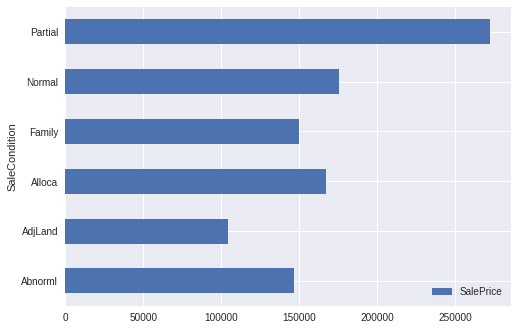

In [221]:
df.pivot_table(index='SaleCondition', values='SalePrice').plot.barh()

In [0]:
df['salecond_partial'] = (df.SaleCondition == 'Partial')
df['salecond_abnorml'] = (df.SaleCondition == 'Abnorml')

In [225]:
features = ['LotArea','OverallQual', 'OverallCond', 'GrLivArea','GarageArea', 'FullBath', 'HalfBath', 'fullhalfbath_interaction', 'BedroomAbvGr',
            'sold_pre_2008', 'age_sold','age_sold_squared', 'years_since_remod', 'age_remod_interaction', '1stFlrSF', '2ndFlrSF', 'floor_interaction', 'mszoning_RL', 'mszoning_c',
            'mszoning_RM', 'mszoning_FV', 'good_area', 'bad_area', 'one_fam_home', 'townhouse', 'miscfeature_isnone', 'has_shed', 'new_home', 'attached_garage',
            'detchd_garage', 'lotarea_squared', 'overallqual_squared', 'overallcond_squared', 'is_start_of_school', 'is_spring', 'remodeled?', 'age_remodeled_interaction_good',
            'sq_footage_fsb', 'sqfootage_fsb_squared', 'grlivarea_squared', 'heating_qual_ex', 'heating_qual_pr', 'heating_qual_fa', 'finished_bsmt', 'pos1_feedr_art', 'pos2_feedr_art',
            'pos1_pos2_sum1', 'pos1_pos2_sum2', 'kitchen_numeric_squared', 'garage_cars_squared', 'atypical_function', 'exterior_exc', 'salecond_abnorml']



X = df[features].values
y = df.loc[:,['logprice']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


lr = LinearRegression()
lr.fit(X_train, y_train)


oos_pred = lr.predict(X_test)
oos_mse = mean_squared_error(y_test, oos_pred)
oos_r2 = r2_score(y_test, oos_pred)
rmse = (np.sqrt(oos_mse))
rmse, oos_r2

(0.11739263940115659, 0.9204141899047777)

In [0]:
df['no_fireplace'] = (df.Fireplaces == 0)
df['two_or_more_fireplaces'] = (df.Fireplaces >= 2)

In [232]:
features = ['LotArea','OverallQual', 'OverallCond', 'GrLivArea','GarageArea', 'FullBath', 'HalfBath', 'fullhalfbath_interaction', 'BedroomAbvGr',
            'sold_pre_2008', 'age_sold','age_sold_squared', 'years_since_remod', 'age_remod_interaction', '1stFlrSF', '2ndFlrSF', 'floor_interaction', 'mszoning_RL', 'mszoning_c',
            'mszoning_RM', 'mszoning_FV', 'good_area', 'bad_area', 'one_fam_home', 'townhouse', 'miscfeature_isnone', 'has_shed', 'new_home', 'attached_garage',
            'detchd_garage', 'lotarea_squared', 'overallqual_squared', 'overallcond_squared', 'is_start_of_school', 'is_spring', 'remodeled?', 'age_remodeled_interaction_good',
            'sq_footage_fsb', 'sqfootage_fsb_squared', 'grlivarea_squared', 'heating_qual_ex', 'heating_qual_pr', 'heating_qual_fa', 'finished_bsmt', 'pos1_feedr_art', 'pos2_feedr_art',
            'pos1_pos2_sum1', 'pos1_pos2_sum2', 'kitchen_numeric_squared', 'garage_cars_squared', 'atypical_function', 'exterior_exc', 'salecond_abnorml', 'no_fireplace']



X = df[features].values
y = df.loc[:,['logprice']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


lr = LinearRegression()
lr.fit(X_train, y_train)


oos_pred = lr.predict(X_test)
oos_mse = mean_squared_error(y_test, oos_pred)
oos_r2 = r2_score(y_test, oos_pred)
rmse = (np.sqrt(oos_mse))
rmse, oos_r2

(0.11659242700654791, 0.9214954926888741)

In [0]:
df.LotFrontage = df.LotFrontage.fillna(0)
df['lotfrontage_squared'] = df.LotFrontage ** 2

In [253]:
features = ['LotArea','OverallQual', 'OverallCond', 'GrLivArea','GarageArea', 'FullBath', 'HalfBath', 'fullhalfbath_interaction', 'BedroomAbvGr',
            'sold_pre_2008', 'age_sold','age_sold_squared', 'years_since_remod', 'age_remod_interaction', '1stFlrSF', '2ndFlrSF', 'floor_interaction', 'mszoning_RL', 'mszoning_c',
            'mszoning_RM', 'mszoning_FV', 'good_area', 'bad_area', 'one_fam_home', 'townhouse', 'miscfeature_isnone', 'has_shed', 'new_home', 'attached_garage',
            'detchd_garage', 'lotarea_squared', 'overallqual_squared', 'overallcond_squared', 'is_start_of_school', 'is_spring', 'remodeled?', 'age_remodeled_interaction_good',
            'sq_footage_fsb', 'sqfootage_fsb_squared', 'grlivarea_squared', 'heating_qual_ex', 'heating_qual_pr', 'heating_qual_fa', 'finished_bsmt', 'pos1_feedr_art', 'pos2_feedr_art',
            'pos1_pos2_sum1', 'pos1_pos2_sum2', 'kitchen_numeric_squared', 'garage_cars_squared', 'atypical_function', 'exterior_exc', 'salecond_abnorml', 'no_fireplace', 'lotfrontage_squared']



X = df[features].values
y = df.loc[:,['logprice']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


lr = LinearRegression()
lr.fit(X_train, y_train)


oos_pred = lr.predict(X_test)
oos_mse = mean_squared_error(y_test, oos_pred)
oos_r2 = r2_score(y_test, oos_pred)
rmse = (np.sqrt(oos_mse))
rmse, oos_r2

(0.11653697505214211, 0.9215701492212575)

In [238]:
df.Electrical.value_counts()

SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

In [0]:
df.Electrical = df.Electrical.fillna('missing')

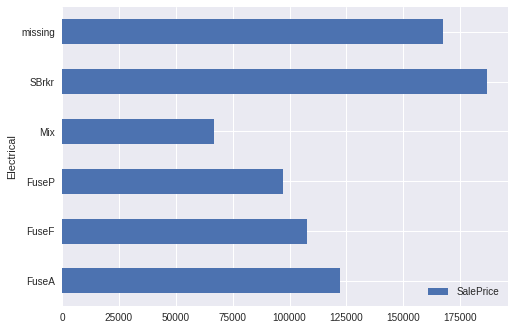

In [241]:
df.pivot_table(index='Electrical', values='SalePrice').plot.barh()

In [245]:
df.Electrical.value_counts()

SBrkr      1334
FuseA        94
FuseF        27
FuseP         3
missing       1
Mix           1
Name: Electrical, dtype: int64

In [0]:
df['electrical_is_brkr'] = (df.Electrical == 'SBrkr')
df['electrical_is_F'] = (df.Electrical == 'FuseF')
df['electrical_is_A'] = (df.Electrical == 'FuseA')
df['electrical_is_P'] = (df.Electrical == 'FuseP')

In [255]:
features = ['LotArea','OverallQual', 'OverallCond', 'GrLivArea','GarageArea', 'FullBath', 'HalfBath', 'fullhalfbath_interaction', 'BedroomAbvGr',
            'sold_pre_2008', 'age_sold','age_sold_squared', 'years_since_remod', 'age_remod_interaction', '1stFlrSF', '2ndFlrSF', 'floor_interaction', 'mszoning_RL', 'mszoning_c',
            'mszoning_RM', 'mszoning_FV', 'good_area', 'bad_area', 'one_fam_home', 'townhouse', 'miscfeature_isnone', 'has_shed', 'new_home', 'attached_garage',
            'detchd_garage', 'lotarea_squared', 'overallqual_squared', 'overallcond_squared', 'is_start_of_school', 'is_spring', 'remodeled?', 'age_remodeled_interaction_good',
            'sq_footage_fsb', 'sqfootage_fsb_squared', 'grlivarea_squared', 'heating_qual_ex', 'heating_qual_pr', 'heating_qual_fa', 'finished_bsmt', 'pos1_feedr_art', 'pos2_feedr_art',
            'pos1_pos2_sum1', 'pos1_pos2_sum2', 'kitchen_numeric_squared', 'garage_cars_squared', 'atypical_function', 'exterior_exc', 'salecond_abnorml', 'no_fireplace', 'lotfrontage_squared']



X = df[features].values
y = df.loc[:,['logprice']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


lr = LinearRegression()
lr.fit(X_train, y_train)


oos_pred = lr.predict(X_test)
oos_mse = mean_squared_error(y_test, oos_pred)
oos_r2 = r2_score(y_test, oos_pred)
rmse = (np.sqrt(oos_mse))
rmse, oos_r2

(0.11653697505214211, 0.9215701492212575)

In [0]:
df['overallcond_5over'] = (df.OverallCond >= 5)

In [257]:
features = ['LotArea','OverallQual', 'OverallCond', 'GrLivArea','GarageArea', 'FullBath', 'HalfBath', 'fullhalfbath_interaction', 'BedroomAbvGr',
            'sold_pre_2008', 'age_sold','age_sold_squared', 'years_since_remod', 'age_remod_interaction', '1stFlrSF', '2ndFlrSF', 'floor_interaction', 'mszoning_RL', 'mszoning_c',
            'mszoning_RM', 'mszoning_FV', 'good_area', 'bad_area', 'one_fam_home', 'townhouse', 'miscfeature_isnone', 'has_shed', 'new_home', 'attached_garage',
            'detchd_garage', 'lotarea_squared', 'overallqual_squared', 'overallcond_squared', 'is_start_of_school', 'is_spring', 'remodeled?', 'age_remodeled_interaction_good',
            'sq_footage_fsb', 'sqfootage_fsb_squared', 'grlivarea_squared', 'heating_qual_ex', 'heating_qual_pr', 'heating_qual_fa', 'finished_bsmt', 'pos1_feedr_art', 'pos2_feedr_art',
            'pos1_pos2_sum1', 'pos1_pos2_sum2', 'kitchen_numeric_squared', 'garage_cars_squared', 'atypical_function', 'exterior_exc', 'salecond_abnorml', 'no_fireplace', 'lotfrontage_squared',
            'overallcond_5over']



X = df[features].values
y = df.loc[:,['logprice']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


lr = LinearRegression()
lr.fit(X_train, y_train)


oos_pred = lr.predict(X_test)
oos_mse = mean_squared_error(y_test, oos_pred)
oos_r2 = r2_score(y_test, oos_pred)
rmse = (np.sqrt(oos_mse))
rmse, oos_r2

(0.11657167806265542, 0.9215234317363747)

In [0]:
df['garagearea_squared'] = df.GarageArea ** 2

In [262]:
features = ['LotArea','OverallQual', 'OverallCond', 'GrLivArea','GarageArea', 'FullBath', 'HalfBath', 'fullhalfbath_interaction', 'BedroomAbvGr',
            'sold_pre_2008', 'age_sold','age_sold_squared', 'years_since_remod', 'age_remod_interaction', '1stFlrSF', '2ndFlrSF', 'floor_interaction', 'mszoning_RL', 'mszoning_c',
            'mszoning_RM', 'mszoning_FV', 'good_area', 'bad_area', 'one_fam_home', 'townhouse', 'miscfeature_isnone', 'has_shed', 'new_home', 'attached_garage',
            'detchd_garage', 'lotarea_squared', 'overallqual_squared', 'overallcond_squared', 'is_start_of_school', 'is_spring', 'remodeled?', 'age_remodeled_interaction_good',
            'sq_footage_fsb', 'sqfootage_fsb_squared', 'grlivarea_squared', 'heating_qual_ex', 'heating_qual_pr', 'heating_qual_fa', 'finished_bsmt', 'pos1_feedr_art', 'pos2_feedr_art',
            'pos1_pos2_sum1', 'pos1_pos2_sum2', 'kitchen_numeric_squared', 'garage_cars_squared', 'atypical_function', 'exterior_exc', 'salecond_abnorml', 'no_fireplace', 'lotfrontage_squared',
            'garagearea_squared']



X = df[features].values
y = df.loc[:,['logprice']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


lr = LinearRegression()
lr.fit(X_train, y_train)


oos_pred = lr.predict(X_test)
oos_mse = mean_squared_error(y_test, oos_pred)
oos_r2 = r2_score(y_test, oos_pred)
rmse = (np.sqrt(oos_mse))
rmse, oos_r2

(0.11652871573637749, 0.9215812659324599)

In [0]:
df['sq_footage_fsbg'] = df['sq_footage_fsb'] + df.GarageArea
df['sq_footage_fsbg_squared'] = df.sq_footage_fsbg ** 2 

In [267]:
features = ['LotArea','OverallQual', 'OverallCond', 'GrLivArea','GarageArea', 'FullBath', 'HalfBath', 'fullhalfbath_interaction', 'BedroomAbvGr',
            'sold_pre_2008', 'age_sold','age_sold_squared', 'years_since_remod', 'age_remod_interaction', '1stFlrSF', '2ndFlrSF', 'floor_interaction', 'mszoning_RL', 'mszoning_c',
            'mszoning_RM', 'mszoning_FV', 'good_area', 'bad_area', 'one_fam_home', 'townhouse', 'miscfeature_isnone', 'has_shed', 'new_home', 'attached_garage',
            'detchd_garage', 'lotarea_squared', 'overallqual_squared', 'overallcond_squared', 'is_start_of_school', 'is_spring', 'remodeled?', 'age_remodeled_interaction_good',
            'sq_footage_fsb', 'sqfootage_fsb_squared', 'grlivarea_squared', 'heating_qual_ex', 'heating_qual_pr', 'heating_qual_fa', 'finished_bsmt', 'pos1_feedr_art', 'pos2_feedr_art',
            'pos1_pos2_sum1', 'pos1_pos2_sum2', 'kitchen_numeric_squared', 'garage_cars_squared', 'atypical_function', 'exterior_exc', 'salecond_abnorml', 'no_fireplace', 'lotfrontage_squared',
            'garagearea_squared', 'sq_footage_fsbg']



X = df[features].values
y = df.loc[:,['logprice']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


lr = LinearRegression()
lr.fit(X_train, y_train)


oos_pred = lr.predict(X_test)
oos_mse = mean_squared_error(y_test, oos_pred)
oos_r2 = r2_score(y_test, oos_pred)
rmse = (np.sqrt(oos_mse))
rmse, oos_r2

(0.11652871605635162, 0.9215812655018027)

In [0]:
df['banked_land'] = (df.LandContour == 'Bnk')
df['HLS_land'] = (df.LandContour == 'HLS_land')

In [274]:
features = ['LotArea','OverallQual', 'OverallCond', 'GrLivArea','GarageArea', 'FullBath', 'HalfBath', 'fullhalfbath_interaction', 'BedroomAbvGr',
            'sold_pre_2008', 'age_sold','age_sold_squared', 'years_since_remod', 'age_remod_interaction', '1stFlrSF', '2ndFlrSF', 'floor_interaction', 'mszoning_RL', 'mszoning_c',
            'mszoning_RM', 'mszoning_FV', 'good_area', 'bad_area', 'one_fam_home', 'townhouse', 'miscfeature_isnone', 'has_shed', 'new_home', 'attached_garage',
            'detchd_garage', 'lotarea_squared', 'overallqual_squared', 'overallcond_squared', 'is_start_of_school', 'is_spring', 'remodeled?', 'age_remodeled_interaction_good',
            'sq_footage_fsb', 'sqfootage_fsb_squared', 'grlivarea_squared', 'heating_qual_ex', 'heating_qual_pr', 'heating_qual_fa', 'finished_bsmt', 'pos1_feedr_art', 'pos2_feedr_art',
            'pos1_pos2_sum1', 'pos1_pos2_sum2', 'kitchen_numeric_squared', 'garage_cars_squared', 'atypical_function', 'exterior_exc', 'salecond_abnorml', 'no_fireplace', 'lotfrontage_squared',
            'garagearea_squared', 'sq_footage_fsbg', 'banked_land', 'HLS_land']



X = df[features].values
y = df.loc[:,['logprice']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


lr = LinearRegression()
lr.fit(X_train, y_train)


oos_pred = lr.predict(X_test)
oos_mse = mean_squared_error(y_test, oos_pred)
oos_r2 = r2_score(y_test, oos_pred)
rmse = (np.sqrt(oos_mse))
rmse, oos_r2

(0.11619218552070094, 0.9220335521573846)

In [0]:
df['landslope_mod_sev'] = (df.LandSlope != 'Gtl')

In [276]:
features = ['LotArea','OverallQual', 'OverallCond', 'GrLivArea','GarageArea', 'FullBath', 'HalfBath', 'fullhalfbath_interaction', 'BedroomAbvGr',
            'sold_pre_2008', 'age_sold','age_sold_squared', 'years_since_remod', 'age_remod_interaction', '1stFlrSF', '2ndFlrSF', 'floor_interaction', 'mszoning_RL', 'mszoning_c',
            'mszoning_RM', 'mszoning_FV', 'good_area', 'bad_area', 'one_fam_home', 'townhouse', 'miscfeature_isnone', 'has_shed', 'new_home', 'attached_garage',
            'detchd_garage', 'lotarea_squared', 'overallqual_squared', 'overallcond_squared', 'is_start_of_school', 'is_spring', 'remodeled?', 'age_remodeled_interaction_good',
            'sq_footage_fsb', 'sqfootage_fsb_squared', 'grlivarea_squared', 'heating_qual_ex', 'heating_qual_pr', 'heating_qual_fa', 'finished_bsmt', 'pos1_feedr_art', 'pos2_feedr_art',
            'pos1_pos2_sum1', 'pos1_pos2_sum2', 'kitchen_numeric_squared', 'garage_cars_squared', 'atypical_function', 'exterior_exc', 'salecond_abnorml', 'no_fireplace', 'lotfrontage_squared',
            'garagearea_squared', 'sq_footage_fsbg', 'banked_land', 'HLS_land', 'landslope_mod_sev']



X = df[features].values
y = df.loc[:,['logprice']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


lr = LinearRegression()
lr.fit(X_train, y_train)


oos_pred = lr.predict(X_test)
oos_mse = mean_squared_error(y_test, oos_pred)
oos_r2 = r2_score(y_test, oos_pred)
rmse = (np.sqrt(oos_mse))
rmse, oos_r2

(0.11652685263988825, 0.9215837734774758)

In [277]:
df['land_interaction'] = df.HLS_land + df.landslope_mod_sev

/usr/local/lib/python3.6/dist-packages/pandas/core/computation/expressions.py:179: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


In [278]:
features = ['LotArea','OverallQual', 'OverallCond', 'GrLivArea','GarageArea', 'FullBath', 'HalfBath', 'fullhalfbath_interaction', 'BedroomAbvGr',
            'sold_pre_2008', 'age_sold','age_sold_squared', 'years_since_remod', 'age_remod_interaction', '1stFlrSF', '2ndFlrSF', 'floor_interaction', 'mszoning_RL', 'mszoning_c',
            'mszoning_RM', 'mszoning_FV', 'good_area', 'bad_area', 'one_fam_home', 'townhouse', 'miscfeature_isnone', 'has_shed', 'new_home', 'attached_garage',
            'detchd_garage', 'lotarea_squared', 'overallqual_squared', 'overallcond_squared', 'is_start_of_school', 'is_spring', 'remodeled?', 'age_remodeled_interaction_good',
            'sq_footage_fsb', 'sqfootage_fsb_squared', 'grlivarea_squared', 'heating_qual_ex', 'heating_qual_pr', 'heating_qual_fa', 'finished_bsmt', 'pos1_feedr_art', 'pos2_feedr_art',
            'pos1_pos2_sum1', 'pos1_pos2_sum2', 'kitchen_numeric_squared', 'garage_cars_squared', 'atypical_function', 'exterior_exc', 'salecond_abnorml', 'no_fireplace', 'lotfrontage_squared',
            'garagearea_squared', 'sq_footage_fsbg', 'banked_land', 'HLS_land', 'landslope_mod_sev', 'land_interaction']



X = df[features].values
y = df.loc[:,['logprice']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


lr = LinearRegression()
lr.fit(X_train, y_train)


oos_pred = lr.predict(X_test)
oos_mse = mean_squared_error(y_test, oos_pred)
oos_r2 = r2_score(y_test, oos_pred)
rmse = (np.sqrt(oos_mse))
rmse, oos_r2

(0.1165268523715938, 0.9215837738385709)

In [341]:
features = ['LotArea','OverallQual', 'OverallCond', 'GrLivArea','GarageArea', 'FullBath', 'HalfBath', 'fullhalfbath_interaction', 'BedroomAbvGr',
            'sold_pre_2008', 'age_sold','age_sold_squared', 'years_since_remod', 'age_remod_interaction', '1stFlrSF', '2ndFlrSF', 'floor_interaction', 'mszoning_RL', 'mszoning_c',
            'mszoning_RM', 'mszoning_FV', 'good_area', 'bad_area', 'one_fam_home', 'townhouse', 'miscfeature_isnone', 'has_shed', 'new_home', 'attached_garage',
            'detchd_garage', 'lotarea_squared', 'overallqual_squared', 'overallcond_squared', 'is_start_of_school', 'is_spring', 'remodeled?', 'age_remodeled_interaction_good',
            'sq_footage_fsb', 'sqfootage_fsb_squared', 'grlivarea_squared', 'heating_qual_ex', 'heating_qual_pr', 'heating_qual_fa', 'finished_bsmt', 'pos1_feedr_art', 'pos2_feedr_art',
            'pos1_pos2_sum1', 'pos1_pos2_sum2', 'kitchen_numeric_squared', 'garage_cars_squared', 'atypical_function', 'exterior_exc', 'salecond_abnorml', 'no_fireplace', 'lotfrontage_squared',
            'garagearea_squared', 'sq_footage_fsbg', 'banked_land', 'HLS_land']



X = df[features].values
y = df.loc[:,['logprice']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


lr = LinearRegression()
lr.fit(X_train, y_train)


oos_pred = lr.predict(X_test)
oos_mse = mean_squared_error(y_test, oos_pred)
oos_r2 = r2_score(y_test, oos_pred)
rmse = (np.sqrt(oos_mse))
rmse, oos_r2

(0.11619218552070094, 0.9220335521573846)

# Stretch Goals

- Write a blog post explaining one of today's topics.
- Find a new regression dataset from the UCI machine learning repository and use it to test out your new modeling skillz.
 [ - UCI Machine Learning Repository - Regression Datasets](https://)
- Make a list for yourself of common feature engineering techniques. Browse Kaggle kernels to learn more methods.
- Start studying for tomorrow's topic: Gradient Descent
- Try and make the ultimate model with this dataset. clean as many features as possible, engineer the most sensible features as possible and see how accurate of a prediction you can make. 
- Learn about the "Dummy Variable Trap" and how it applies to linear regression modeling.
- Learning about using linear regression to model time series data

In [343]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

features = ['LotArea','OverallQual', 'OverallCond', 'GrLivArea','GarageArea', 'FullBath', 'HalfBath', 'fullhalfbath_interaction', 'BedroomAbvGr',
            'sold_pre_2008', 'age_sold','age_sold_squared', 'years_since_remod', 'age_remod_interaction', '1stFlrSF', '2ndFlrSF', 'floor_interaction', 'mszoning_RL', 'mszoning_c',
            'mszoning_RM', 'mszoning_FV', 'good_area', 'bad_area', 'one_fam_home', 'townhouse', 'miscfeature_isnone', 'has_shed', 'new_home', 'attached_garage',
            'detchd_garage', 'lotarea_squared', 'overallqual_squared', 'overallcond_squared', 'is_start_of_school', 'is_spring', 'remodeled?', 'age_remodeled_interaction_good',
            'sq_footage_fsb', 'sqfootage_fsb_squared', 'grlivarea_squared', 'heating_qual_ex', 'heating_qual_pr', 'heating_qual_fa', 'finished_bsmt', 'pos1_feedr_art', 'pos2_feedr_art',
            'pos1_pos2_sum1', 'pos1_pos2_sum2', 'kitchen_numeric_squared', 'garage_cars_squared', 'atypical_function', 'exterior_exc', 'salecond_abnorml', 'no_fireplace', 'lotfrontage_squared',
            'garagearea_squared', 'sq_footage_fsbg', 'banked_land', 'HLS_land']


X = df[features].values
y = df.logprice

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


lr = Ridge()
lr.fit(X_train, y_train)


oos_pred = lr.predict(X_test)
oos_mse = mean_squared_error(y_test, oos_pred)
oos_r2 = r2_score(y_test, oos_pred)
rmse = (np.sqrt(oos_mse))
rmse, oos_r2

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.676697e-22
  overwrite_a=True).T


(0.1172621461198108, 0.9205910262271344)

In [342]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

features = ['LotArea','OverallQual', 'OverallCond', 'GrLivArea','GarageArea', 'FullBath', 'HalfBath', 'fullhalfbath_interaction', 'BedroomAbvGr',
            'sold_pre_2008', 'age_sold','age_sold_squared', 'years_since_remod', 'age_remod_interaction', '1stFlrSF', '2ndFlrSF', 'floor_interaction', 'mszoning_RL', 'mszoning_c',
            'mszoning_RM', 'mszoning_FV', 'good_area', 'bad_area', 'one_fam_home', 'townhouse', 'miscfeature_isnone', 'has_shed', 'new_home', 'attached_garage',
            'detchd_garage', 'lotarea_squared', 'overallqual_squared', 'overallcond_squared', 'is_start_of_school', 'is_spring', 'remodeled?', 'age_remodeled_interaction_good',
            'sq_footage_fsb', 'sqfootage_fsb_squared', 'grlivarea_squared', 'heating_qual_ex', 'heating_qual_pr', 'heating_qual_fa', 'finished_bsmt', 'pos1_feedr_art', 'pos2_feedr_art',
            'pos1_pos2_sum1', 'pos1_pos2_sum2', 'kitchen_numeric_squared', 'garage_cars_squared', 'atypical_function', 'exterior_exc', 'salecond_abnorml', 'no_fireplace', 'lotfrontage_squared',
            'garagearea_squared', 'sq_footage_fsbg', 'banked_land', 'HLS_land']


X = df[features].values
y = df.logprice

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


lr = GradientBoostingRegressor(n_estimators=1000)
lr.fit(X_train, y_train)


oos_pred = lr.predict(X_test)
oos_mse = mean_squared_error(y_test, oos_pred)
oos_r2 = r2_score(y_test, oos_pred)
rmse = (np.sqrt(oos_mse))
rmse, oos_r2

(0.1260510965933175, 0.9082413187484265)

In [344]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

features = ['LotArea','OverallQual', 'OverallCond', 'GrLivArea','GarageArea', 'FullBath', 'HalfBath', 'fullhalfbath_interaction', 'BedroomAbvGr',
            'sold_pre_2008', 'age_sold','age_sold_squared', 'years_since_remod', 'age_remod_interaction', '1stFlrSF', '2ndFlrSF', 'floor_interaction', 'mszoning_RL', 'mszoning_c',
            'mszoning_RM', 'mszoning_FV', 'good_area', 'bad_area', 'one_fam_home', 'townhouse', 'miscfeature_isnone', 'has_shed', 'new_home', 'attached_garage',
            'detchd_garage', 'lotarea_squared', 'overallqual_squared', 'overallcond_squared', 'is_start_of_school', 'is_spring', 'remodeled?', 'age_remodeled_interaction_good',
            'sq_footage_fsb', 'sqfootage_fsb_squared', 'grlivarea_squared', 'heating_qual_ex', 'heating_qual_pr', 'heating_qual_fa', 'finished_bsmt', 'pos1_feedr_art', 'pos2_feedr_art',
            'pos1_pos2_sum1', 'pos1_pos2_sum2', 'kitchen_numeric_squared', 'garage_cars_squared', 'atypical_function', 'exterior_exc', 'salecond_abnorml', 'no_fireplace', 'lotfrontage_squared',
            'garagearea_squared', 'sq_footage_fsbg', 'banked_land', 'HLS_land']


X = df[features].values
y = df.logprice

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


lr = RandomForestRegressor(n_estimators=300,max_features=10)
lr.fit(X_train, y_train)


oos_pred = lr.predict(X_test)
oos_mse = mean_squared_error(y_test, oos_pred)
oos_r2 = r2_score(y_test, oos_pred)
rmse = (np.sqrt(oos_mse))
rmse, oos_r2

(0.1339719596767472, 0.8963470356285553)

In [360]:
features = ['LotArea','OverallQual', 'OverallCond', 'GrLivArea','GarageArea', 'FullBath', 'HalfBath', 'fullhalfbath_interaction', 'BedroomAbvGr',
            'sold_pre_2008', 'age_sold','age_sold_squared', 'years_since_remod', 'age_remod_interaction', '1stFlrSF', '2ndFlrSF', 'floor_interaction', 'mszoning_RL', 'mszoning_c',
            'mszoning_RM', 'mszoning_FV', 'good_area', 'bad_area', 'one_fam_home', 'townhouse', 'miscfeature_isnone', 'has_shed', 'new_home', 'attached_garage',
            'detchd_garage', 'lotarea_squared', 'overallqual_squared', 'overallcond_squared', 'is_start_of_school', 'is_spring', 'remodeled?', 'age_remodeled_interaction_good',
            'sq_footage_fsb', 'sqfootage_fsb_squared', 'grlivarea_squared', 'heating_qual_ex', 'heating_qual_pr', 'heating_qual_fa', 'finished_bsmt', 'pos1_feedr_art', 'pos2_feedr_art',
            'pos1_pos2_sum1', 'pos1_pos2_sum2', 'kitchen_numeric_squared', 'garage_cars_squared', 'atypical_function', 'exterior_exc', 'salecond_abnorml', 'no_fireplace', 'lotfrontage_squared',
            'garagearea_squared', 'sq_footage_fsbg', 'banked_land', 'HLS_land']



X = df[features].values
y = df.loc[:,['logprice']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


lr = LinearRegression()
lr.fit(X_train, y_train)


oos_pred = lr.predict(X_test)
oos_mse = mean_squared_error(y_test, oos_pred)
oos_r2 = r2_score(y_test, oos_pred)
rmse = (np.sqrt(oos_mse))
rmse, oos_r2

(0.11619218552070094, 0.9220335521573846)

In [362]:
df.SaleCondition.value_counts()

Normal     1198
Partial     125
Abnorml     101
Family       20
Alloca       12
AdjLand       4
Name: SaleCondition, dtype: int64

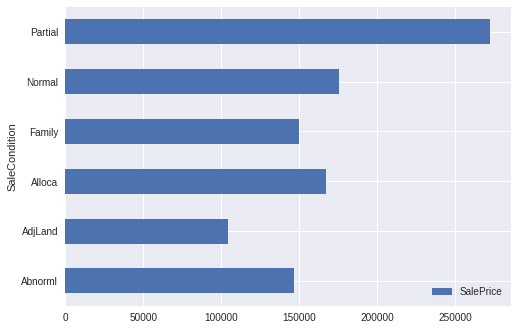

In [364]:
df.pivot_table(index='SaleCondition', values='SalePrice').plot.barh()

In [0]:
df['salecond_adjland'] = (df.SaleCondition == 'AdjLand')
df['salecond_alloca'] = (df.SaleCondition == 'Alloca') 

In [368]:
features = ['LotArea','OverallQual', 'OverallCond', 'GrLivArea','GarageArea', 'FullBath', 'HalfBath', 'fullhalfbath_interaction', 'BedroomAbvGr',
            'sold_pre_2008', 'age_sold','age_sold_squared', 'years_since_remod', 'age_remod_interaction', '1stFlrSF', '2ndFlrSF', 'floor_interaction', 'mszoning_RL', 'mszoning_c',
            'mszoning_RM', 'mszoning_FV', 'good_area', 'bad_area', 'one_fam_home', 'townhouse', 'miscfeature_isnone', 'has_shed', 'new_home', 'attached_garage',
            'detchd_garage', 'lotarea_squared', 'overallqual_squared', 'overallcond_squared', 'is_start_of_school', 'is_spring', 'remodeled?', 'age_remodeled_interaction_good',
            'sq_footage_fsb', 'sqfootage_fsb_squared', 'grlivarea_squared', 'heating_qual_ex', 'heating_qual_pr', 'heating_qual_fa', 'finished_bsmt', 'pos1_feedr_art', 'pos2_feedr_art',
            'pos1_pos2_sum1', 'pos1_pos2_sum2', 'kitchen_numeric_squared', 'garage_cars_squared', 'atypical_function', 'exterior_exc', 'salecond_abnorml', 'no_fireplace', 'lotfrontage_squared',
            'garagearea_squared', 'sq_footage_fsbg', 'banked_land', 'HLS_land']



X = df[features].values
y = df.loc[:,['logprice']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


lr = LinearRegression()
lr.fit(X_train, y_train)


oos_pred = lr.predict(X_test)
oos_mse = mean_squared_error(y_test, oos_pred)
oos_r2 = r2_score(y_test, oos_pred)
rmse = (np.sqrt(oos_mse))
rmse, oos_r2

(0.11619218552070094, 0.9220335521573846)

In [0]:
df['salecond_family'] = (df.SaleCondition == 'Family')

In [372]:
features = ['LotArea','OverallQual', 'OverallCond', 'GrLivArea','GarageArea', 'FullBath', 'HalfBath', 'fullhalfbath_interaction', 'BedroomAbvGr',
            'sold_pre_2008', 'age_sold','age_sold_squared', 'years_since_remod', 'age_remod_interaction', '1stFlrSF', '2ndFlrSF', 'floor_interaction', 'mszoning_RL', 'mszoning_c',
            'mszoning_RM', 'mszoning_FV', 'good_area', 'bad_area', 'one_fam_home', 'townhouse', 'miscfeature_isnone', 'has_shed', 'new_home', 'attached_garage',
            'detchd_garage', 'lotarea_squared', 'overallqual_squared', 'overallcond_squared', 'is_start_of_school', 'is_spring', 'remodeled?', 'age_remodeled_interaction_good',
            'sq_footage_fsb', 'sqfootage_fsb_squared', 'grlivarea_squared', 'heating_qual_ex', 'heating_qual_pr', 'heating_qual_fa', 'finished_bsmt', 'pos1_feedr_art', 'pos2_feedr_art',
            'pos1_pos2_sum1', 'pos1_pos2_sum2', 'kitchen_numeric_squared', 'garage_cars_squared', 'atypical_function', 'exterior_exc', 'salecond_abnorml', 'no_fireplace', 'lotfrontage_squared',
            'garagearea_squared', 'sq_footage_fsbg', 'banked_land', 'HLS_land', 'salecond_family']



X = df[features].values
y = df.loc[:,['logprice']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


lr = LinearRegression()
lr.fit(X_train, y_train)


oos_pred = lr.predict(X_test)
oos_mse = mean_squared_error(y_test, oos_pred)
oos_r2 = r2_score(y_test, oos_pred)
rmse = (np.sqrt(oos_mse))
rmse, oos_r2

(0.11582708418637891, 0.9225227577153594)

In [373]:
df.PoolArea.value_counts()

0      1453
738       1
648       1
576       1
555       1
519       1
512       1
480       1
Name: PoolArea, dtype: int64

In [0]:
df['has_pool'] = (df.PoolArea > 0)

In [379]:
features = ['LotArea','OverallQual', 'OverallCond', 'GrLivArea','GarageArea', 'FullBath', 'HalfBath', 'fullhalfbath_interaction', 'BedroomAbvGr',
            'sold_pre_2008', 'age_sold','age_sold_squared', 'years_since_remod', 'age_remod_interaction', '1stFlrSF', '2ndFlrSF', 'floor_interaction', 'mszoning_RL', 'mszoning_c',
            'mszoning_RM', 'mszoning_FV', 'good_area', 'bad_area', 'one_fam_home', 'townhouse', 'miscfeature_isnone', 'has_shed', 'new_home', 'attached_garage',
            'detchd_garage', 'lotarea_squared', 'overallqual_squared', 'overallcond_squared', 'is_start_of_school', 'is_spring', 'remodeled?', 'age_remodeled_interaction_good',
            'sq_footage_fsb', 'sqfootage_fsb_squared', 'grlivarea_squared', 'heating_qual_ex', 'heating_qual_pr', 'heating_qual_fa', 'finished_bsmt', 'pos1_feedr_art', 'pos2_feedr_art',
            'pos1_pos2_sum1', 'pos1_pos2_sum2', 'kitchen_numeric_squared', 'garage_cars_squared', 'atypical_function', 'exterior_exc', 'salecond_abnorml', 'no_fireplace', 'lotfrontage_squared',
            'garagearea_squared', 'sq_footage_fsbg', 'banked_land', 'HLS_land', 'salecond_family', 'has_pool']



X = df[features].values
y = df.loc[:,['logprice']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


lr = LinearRegression()
lr.fit(X_train, y_train)


oos_pred = lr.predict(X_test)
oos_mse = mean_squared_error(y_test, oos_pred)
oos_r2 = r2_score(y_test, oos_pred)
rmse = (np.sqrt(oos_mse))
rmse, oos_r2

(0.1161828020436709, 0.9220461445159489)

In [380]:
features = ['LotArea','OverallQual', 'OverallCond', 'GrLivArea','GarageArea', 'FullBath', 'HalfBath', 'fullhalfbath_interaction', 'BedroomAbvGr',
            'sold_pre_2008', 'age_sold','age_sold_squared', 'years_since_remod', 'age_remod_interaction', '1stFlrSF', '2ndFlrSF', 'floor_interaction', 'mszoning_RL', 'mszoning_c',
            'mszoning_RM', 'mszoning_FV', 'good_area', 'bad_area', 'one_fam_home', 'townhouse', 'miscfeature_isnone', 'has_shed', 'new_home', 'attached_garage',
            'detchd_garage', 'lotarea_squared', 'overallqual_squared', 'overallcond_squared', 'is_start_of_school', 'is_spring', 'remodeled?', 'age_remodeled_interaction_good',
            'sq_footage_fsb', 'sqfootage_fsb_squared', 'grlivarea_squared', 'heating_qual_ex', 'heating_qual_pr', 'heating_qual_fa', 'finished_bsmt', 'pos1_feedr_art', 'pos2_feedr_art',
            'pos1_pos2_sum1', 'pos1_pos2_sum2', 'kitchen_numeric_squared', 'garage_cars_squared', 'atypical_function', 'exterior_exc', 'salecond_abnorml', 'no_fireplace', 'lotfrontage_squared',
            'garagearea_squared', 'sq_footage_fsbg', 'banked_land', 'HLS_land', 'salecond_family']



X = df[features].values
y = df.loc[:,['logprice']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


lr = LinearRegression()
lr.fit(X_train, y_train)


oos_pred = lr.predict(X_test)
oos_mse = mean_squared_error(y_test, oos_pred)
oos_r2 = r2_score(y_test, oos_pred)
rmse = (np.sqrt(oos_mse))
rmse, oos_r2

(0.11582708418637891, 0.9225227577153594)

In [0]:
df['pool_exc'] = (df.PoolQC == 'Ex')

In [386]:
features = ['LotArea','OverallQual', 'OverallCond', 'GrLivArea','GarageArea', 'FullBath', 'HalfBath', 'fullhalfbath_interaction', 'BedroomAbvGr',
            'sold_pre_2008', 'age_sold','age_sold_squared', 'years_since_remod', 'age_remod_interaction', '1stFlrSF', '2ndFlrSF', 'floor_interaction', 'mszoning_RL', 'mszoning_c',
            'mszoning_RM', 'mszoning_FV', 'good_area', 'bad_area', 'one_fam_home', 'townhouse', 'miscfeature_isnone', 'has_shed', 'new_home', 'attached_garage',
            'detchd_garage', 'lotarea_squared', 'overallqual_squared', 'overallcond_squared', 'is_start_of_school', 'is_spring', 'remodeled?', 'age_remodeled_interaction_good',
            'sq_footage_fsb', 'sqfootage_fsb_squared', 'grlivarea_squared', 'heating_qual_ex', 'heating_qual_pr', 'heating_qual_fa', 'finished_bsmt', 'pos1_feedr_art', 'pos2_feedr_art',
            'pos1_pos2_sum1', 'pos1_pos2_sum2', 'kitchen_numeric_squared', 'garage_cars_squared', 'atypical_function', 'exterior_exc', 'salecond_abnorml', 'no_fireplace', 'lotfrontage_squared',
            'garagearea_squared', 'sq_footage_fsbg', 'banked_land', 'HLS_land', 'salecond_family']



X = df[features].values
y = df.loc[:,['logprice']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


lr = LinearRegression()
lr.fit(X_train, y_train)


oos_pred = lr.predict(X_test)
oos_mse = mean_squared_error(y_test, oos_pred)
oos_r2 = r2_score(y_test, oos_pred)
rmse = (np.sqrt(oos_mse))
rmse, oos_r2

(0.11582708418637891, 0.9225227577153594)

In [387]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,matching_exterior_type,logprice,fullhalfbath_interaction,sold_pre_2008,age_sold,years_since_remod,age_remod_interaction,age_sold_squared,years_since_remod_squared,age_remod_interaction_squared,floor_interaction,mszoning_RL,mszoning_c,mszoning_RM,mszoning_FV,good_area,bad_area,one_fam_home,townhouse,miscfeature_isnone,has_shed,new_home,saletype_cod,saletype_lowdn_lowint,attached_garage,detchd_garage,lotarea_squared,overallqual_squared,overallcond_squared,is_start_of_school,is_spring,remodeled?,age_remodeled_interaction_good,sq_footage_fsb,sqfootage_fsb_squared,fullbath_squared,grlivarea_squared,heating_gasa,heating_qual_ex,heating_qual_pr,heating_qual_fa,bsmt_unfin_percent,finished_bsmt,pos1_feedr_art,pos2_feedr_art,pos1_pos2_sum1,pos1_pos2_sum2,onehalf_fin,onehalf_unfin,kitchen_numeric,kitchen_numeric_squared,garage_cars_squared,atypical_function,exterior_exc,salecond_partial,salecond_abnorml,no_fireplace,two_or_more_fireplaces,lotfrontage_squared,electrical_is_brkr,electrical_is_F,electrical_is_A,electrical_is_P,overallcond_5over,garagearea_squared,sq_footage_fsbg,sq_footage_fsbg_squared,banked_land,HLS_land,landslope_mod_sev,land_interaction,salecond_adjland,salecond_alloca,salecond_family,has_pool,pool_exc
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,None,0,2,2008,WD,Normal,208500,True,12.247694,2,False,5,5,25,25,5,125,731024,True,False,False,False,False,False,True,False,True,False,False,False,False,True,False,71402500,49,25,False,False,False,0,2416,5837056,4,2924100,True,True,False,False,0.175234,False,False,False,False,False,False,False,4,16,4,False,False,False,False,True,False,4225.0,True,False,False,False,True,300304,2964,8785296,False,False,False,False,False,False,False,False,False
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,None,0,5,2007,WD,Normal,181500,True,12.109011,0,True,31,31,961,961,31,29791,0,True,False,False,False,False,False,True,False,True,False,False,False,False,True,False,92160000,36,64,False,True,False,0,2240,5017600,4,1592644,True,True,False,False,0.225040,False,True,False,True,False,False,False,3,9,4,False,False,False,False,False,False,6400.0,True,False,False,False,True,211600,2700,7290000,False,False,False,False,False,False,False,False,False
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,None,0,9,2008,WD,Normal,223500,True,12.317167,2,False,7,6,42,49,6,294,796720,True,False,False,False,False,False,True,False,True,False,False,Fa

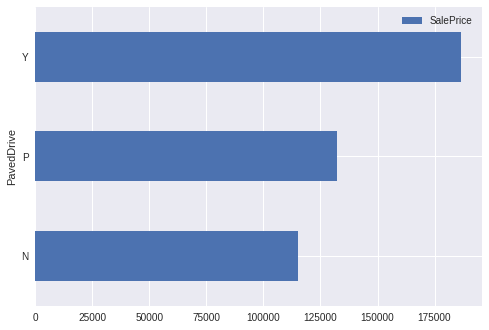

In [392]:
df.pivot_table(index='PavedDrive', values='SalePrice').plot.barh()

In [393]:
df.PavedDrive.value_counts()

Y    1340
N      90
P      30
Name: PavedDrive, dtype: int64

In [0]:
df['paved_drive_numeric'] = df.PavedDrive.map({'Y': 2, 'P': 1, 'N': 0})
df['paved_drive_squared'] = df.paved_drive_numeric ** 2

In [416]:
features = ['LotArea','OverallQual', 'OverallCond', 'GrLivArea','GarageArea', 'FullBath', 'HalfBath', 'fullhalfbath_interaction', 'BedroomAbvGr',
            'sold_pre_2008', 'age_sold','age_sold_squared', 'years_since_remod', 'age_remod_interaction', '1stFlrSF', '2ndFlrSF', 'floor_interaction', 'mszoning_RL', 'mszoning_c',
            'mszoning_RM', 'mszoning_FV', 'good_area', 'bad_area', 'one_fam_home', 'townhouse', 'miscfeature_isnone', 'has_shed', 'new_home', 'attached_garage',
            'detchd_garage', 'lotarea_squared', 'overallqual_squared', 'overallcond_squared', 'is_start_of_school', 'is_spring', 'remodeled?', 'age_remodeled_interaction_good',
            'sq_footage_fsb', 'sqfootage_fsb_squared', 'grlivarea_squared', 'heating_qual_ex', 'heating_qual_pr', 'heating_qual_fa', 'finished_bsmt', 'pos1_feedr_art', 'pos2_feedr_art',
            'pos1_pos2_sum1', 'pos1_pos2_sum2', 'kitchen_numeric_squared', 'garage_cars_squared', 'atypical_function', 'exterior_exc', 'salecond_abnorml', 'no_fireplace', 'lotfrontage_squared',
            'garagearea_squared', 'sq_footage_fsbg', 'banked_land', 'HLS_land', 'salecond_family', 'paved_drive_numeric', 'paved_drive_squared']



X = df[features].values
y = df.loc[:,['logprice']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


lr = LinearRegression()
lr.fit(X_train, y_train)


oos_pred = lr.predict(X_test)
oos_mse = mean_squared_error(y_test, oos_pred)
oos_r2 = r2_score(y_test, oos_pred)
rmse = (np.sqrt(oos_mse))
rmse, oos_r2

(0.1155816036866106, 0.9228508156644238)

In [417]:
df.WoodDeckSF.corr(df.SalePrice)

0.3244134445681294

In [418]:
df.OpenPorchSF.corr(df.SalePrice)

0.3158562271160555

In [419]:
df.EnclosedPorch.corr(df.SalePrice)

-0.12857795792595653

In [420]:
df['3SsnPorch'].corr(df.SalePrice)

0.04458366533574846

In [430]:
features = ['LotArea','OverallQual', 'OverallCond', 'GrLivArea','GarageArea', 'FullBath', 'HalfBath', 'fullhalfbath_interaction', 'BedroomAbvGr',
            'sold_pre_2008', 'age_sold','age_sold_squared', 'years_since_remod', 'age_remod_interaction', '1stFlrSF', '2ndFlrSF', 'floor_interaction', 'mszoning_RL', 'mszoning_c',
            'mszoning_RM', 'mszoning_FV', 'good_area', 'bad_area', 'one_fam_home', 'townhouse', 'miscfeature_isnone', 'has_shed', 'new_home', 'attached_garage',
            'detchd_garage', 'lotarea_squared', 'overallqual_squared', 'overallcond_squared', 'is_start_of_school', 'is_spring', 'remodeled?', 'age_remodeled_interaction_good',
            'sq_footage_fsb', 'sqfootage_fsb_squared', 'grlivarea_squared', 'heating_qual_ex', 'heating_qual_pr', 'heating_qual_fa', 'finished_bsmt', 'pos1_feedr_art', 'pos2_feedr_art',
            'pos1_pos2_sum1', 'pos1_pos2_sum2', 'kitchen_numeric_squared', 'garage_cars_squared', 'atypical_function', 'exterior_exc', 'salecond_abnorml', 'no_fireplace', 'lotfrontage_squared',
            'garagearea_squared', 'sq_footage_fsbg', 'banked_land', 'HLS_land', 'salecond_family', 'paved_drive_numeric', 'paved_drive_squared', 'OpenPorchSF', 'WoodDeckSF', 'EnclosedPorch',
            'ScreenPorch']



X = df[features].values
y = df.loc[:,['logprice']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


lr = LinearRegression()
lr.fit(X_train, y_train)


oos_pred = lr.predict(X_test)
oos_mse = mean_squared_error(y_test, oos_pred)
oos_r2 = r2_score(y_test, oos_pred)
rmse = (np.sqrt(oos_mse))
rmse, oos_r2

(0.11464563857309795, 0.9240952451126676)

In [0]:
df['OpenPorchSF_squared'] = df.OpenPorchSF ** 2
df['WoodDeckSF_squared'] = df.WoodDeckSF ** 2
df['EnclosedPorch_squared'] = df.EnclosedPorch ** 2
df['ScreenPorch_squared'] = df.ScreenPorch ** 2

In [437]:
features = ['LotArea','OverallQual', 'OverallCond', 'GrLivArea','GarageArea', 'FullBath', 'HalfBath', 'fullhalfbath_interaction', 'BedroomAbvGr',
            'sold_pre_2008', 'age_sold','age_sold_squared', 'years_since_remod', 'age_remod_interaction', '1stFlrSF', '2ndFlrSF', 'floor_interaction', 'mszoning_RL', 'mszoning_c',
            'mszoning_RM', 'mszoning_FV', 'good_area', 'bad_area', 'one_fam_home', 'townhouse', 'miscfeature_isnone', 'has_shed', 'new_home', 'attached_garage',
            'detchd_garage', 'lotarea_squared', 'overallqual_squared', 'overallcond_squared', 'is_start_of_school', 'is_spring', 'remodeled?', 'age_remodeled_interaction_good',
            'sq_footage_fsb', 'sqfootage_fsb_squared', 'grlivarea_squared', 'heating_qual_ex', 'heating_qual_pr', 'heating_qual_fa', 'finished_bsmt', 'pos1_feedr_art', 'pos2_feedr_art',
            'pos1_pos2_sum1', 'pos1_pos2_sum2', 'kitchen_numeric_squared', 'garage_cars_squared', 'atypical_function', 'exterior_exc', 'salecond_abnorml', 'no_fireplace', 'lotfrontage_squared',
            'garagearea_squared', 'sq_footage_fsbg', 'banked_land', 'HLS_land', 'salecond_family', 'paved_drive_numeric', 'paved_drive_squared', 'OpenPorchSF', 'WoodDeckSF', 'EnclosedPorch',
            'ScreenPorch']



X = df[features].values
y = df.loc[:,['logprice']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


lr = LinearRegression()
lr.fit(X_train, y_train)


oos_pred = lr.predict(X_test)
oos_mse = mean_squared_error(y_test, oos_pred)
oos_r2 = r2_score(y_test, oos_pred)
rmse = (np.sqrt(oos_mse))
rmse, oos_r2

(0.11464563857309795, 0.9240952451126676)

In [438]:
df.GarageQual.value_counts()

TA    1311
Fa      48
Gd      14
Ex       3
Po       3
Name: GarageQual, dtype: int64

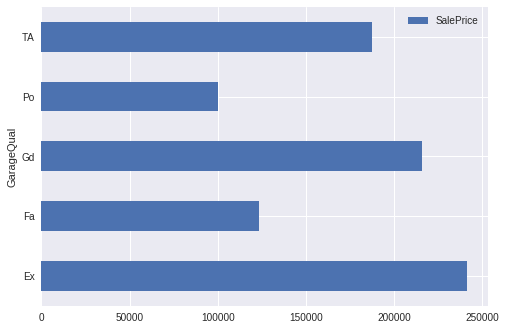

In [440]:
df.pivot_table(index='GarageQual', values='SalePrice').plot.barh()

In [0]:
# df['GarageQual_numeric']

df.GarageQual = df.GarageQual.fillna('missing')

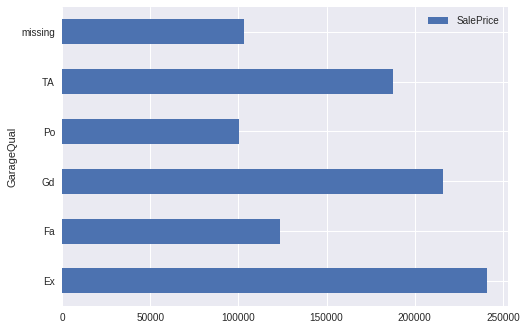

In [444]:
df.pivot_table(index='GarageQual', values='SalePrice').plot.barh()

In [0]:
df.GarageQual = df.GarageQual.fillna('missing')
df['garageQual_numeric'] = df.GarageQual.map({'missing': 0, 'Po': 0, 'Fa': 1, 'TA': 2, 'Gd':3, 'Ex': 4})

In [447]:
features = ['LotArea','OverallQual', 'OverallCond', 'GrLivArea','GarageArea', 'FullBath', 'HalfBath', 'fullhalfbath_interaction', 'BedroomAbvGr',
            'sold_pre_2008', 'age_sold','age_sold_squared', 'years_since_remod', 'age_remod_interaction', '1stFlrSF', '2ndFlrSF', 'floor_interaction', 'mszoning_RL', 'mszoning_c',
            'mszoning_RM', 'mszoning_FV', 'good_area', 'bad_area', 'one_fam_home', 'townhouse', 'miscfeature_isnone', 'has_shed', 'new_home', 'attached_garage',
            'detchd_garage', 'lotarea_squared', 'overallqual_squared', 'overallcond_squared', 'is_start_of_school', 'is_spring', 'remodeled?', 'age_remodeled_interaction_good',
            'sq_footage_fsb', 'sqfootage_fsb_squared', 'grlivarea_squared', 'heating_qual_ex', 'heating_qual_pr', 'heating_qual_fa', 'finished_bsmt', 'pos1_feedr_art', 'pos2_feedr_art',
            'pos1_pos2_sum1', 'pos1_pos2_sum2', 'kitchen_numeric_squared', 'garage_cars_squared', 'atypical_function', 'exterior_exc', 'salecond_abnorml', 'no_fireplace', 'lotfrontage_squared',
            'garagearea_squared', 'sq_footage_fsbg', 'banked_land', 'HLS_land', 'salecond_family', 'paved_drive_numeric', 'paved_drive_squared', 'OpenPorchSF', 'WoodDeckSF', 'EnclosedPorch',
            'ScreenPorch', 'garageQual_numeric']



X = df[features].values
y = df.loc[:,['logprice']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


lr = LinearRegression()
lr.fit(X_train, y_train)


oos_pred = lr.predict(X_test)
oos_mse = mean_squared_error(y_test, oos_pred)
oos_r2 = r2_score(y_test, oos_pred)
rmse = (np.sqrt(oos_mse))
rmse, oos_r2

(0.11494503940940237, 0.923698271932472)

In [0]:
df.GarageQual = df.GarageQual.fillna('missing')
df['garageQual_numeric'] = df.GarageQual.map({'missing': 0, 'Po': 0, 'Fa': 1, 'TA': 2, 'Gd':3, 'Ex': 4})
df['garageQual_numeric_squared'] = df.garageQual_numeric ** 2

In [456]:
features = ['LotArea','OverallQual', 'OverallCond', 'GrLivArea','GarageArea', 'FullBath', 'HalfBath', 'fullhalfbath_interaction', 'BedroomAbvGr',
            'sold_pre_2008', 'age_sold','age_sold_squared', 'years_since_remod', 'age_remod_interaction', '1stFlrSF', '2ndFlrSF', 'floor_interaction', 'mszoning_RL', 'mszoning_c',
            'mszoning_RM', 'mszoning_FV', 'good_area', 'bad_area', 'one_fam_home', 'townhouse', 'miscfeature_isnone', 'has_shed', 'new_home', 'attached_garage',
            'detchd_garage', 'lotarea_squared', 'overallqual_squared', 'overallcond_squared', 'is_start_of_school', 'is_spring', 'remodeled?', 'age_remodeled_interaction_good',
            'sq_footage_fsb', 'sqfootage_fsb_squared', 'grlivarea_squared', 'heating_qual_ex', 'heating_qual_pr', 'heating_qual_fa', 'finished_bsmt', 'pos1_feedr_art', 'pos2_feedr_art',
            'pos1_pos2_sum1', 'pos1_pos2_sum2', 'kitchen_numeric_squared', 'garage_cars_squared', 'atypical_function', 'exterior_exc', 'salecond_abnorml', 'no_fireplace', 'lotfrontage_squared',
            'garagearea_squared', 'sq_footage_fsbg', 'banked_land', 'HLS_land', 'salecond_family', 'paved_drive_numeric', 'paved_drive_squared', 'OpenPorchSF', 'WoodDeckSF', 'EnclosedPorch',
            'ScreenPorch', 'garageQual_numeric_squared']



X = df[features].values
y = df.loc[:,['logprice']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


lr = LinearRegression()
lr.fit(X_train, y_train)


oos_pred = lr.predict(X_test)
oos_mse = mean_squared_error(y_test, oos_pred)
oos_r2 = r2_score(y_test, oos_pred)
rmse = (np.sqrt(oos_mse))
rmse, oos_r2

(0.11474459909345137, 0.9239641486997976)

In [457]:
df.GarageFinish.value_counts()

Unf    605
RFn    422
Fin    352
Name: GarageFinish, dtype: int64

In [458]:
df.pivot_table(index='GarageFinish', values='SalePrice')

,SalePrice
GarageFinish,
Fin,240052.690341
RFn,202068.869668
Unf,142156.423140


In [0]:
df['garage_unf'] = (df.GarageFinish == 'Unf')
df['garage_Fin'] = (df.GarageFinish == 'Fin')

In [485]:
features = ['LotArea','OverallQual', 'OverallCond', 'GrLivArea','GarageArea', 'FullBath', 'HalfBath', 'fullhalfbath_interaction', 'BedroomAbvGr',
            'sold_pre_2008', 'age_sold','age_sold_squared', 'years_since_remod', 'age_remod_interaction', '1stFlrSF', '2ndFlrSF', 'floor_interaction', 'mszoning_RL', 'mszoning_c',
            'mszoning_RM', 'mszoning_FV', 'good_area', 'bad_area', 'one_fam_home', 'townhouse', 'miscfeature_isnone', 'has_shed', 'new_home', 'attached_garage',
            'detchd_garage', 'lotarea_squared', 'overallqual_squared', 'overallcond_squared', 'is_start_of_school', 'is_spring', 'remodeled?', 'age_remodeled_interaction_good',
            'sq_footage_fsb', 'sqfootage_fsb_squared', 'grlivarea_squared', 'heating_qual_ex', 'heating_qual_pr', 'heating_qual_fa', 'finished_bsmt', 'pos1_feedr_art', 'pos2_feedr_art',
            'pos1_pos2_sum1', 'pos1_pos2_sum2', 'kitchen_numeric_squared', 'garage_cars_squared', 'atypical_function', 'exterior_exc', 'salecond_abnorml', 'no_fireplace', 'lotfrontage_squared',
            'garagearea_squared', 'sq_footage_fsbg', 'banked_land', 'HLS_land', 'salecond_family', 'paved_drive_numeric', 'paved_drive_squared', 'OpenPorchSF', 'WoodDeckSF', 'EnclosedPorch',
            'ScreenPorch', 'garageQual_numeric_squared', 'garage_unf', 'garage_Fin']



X = df[features].values
y = df.loc[:,['logprice']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


lr = LinearRegression()
lr.fit(X_train, y_train)


oos_pred = lr.predict(X_test)
oos_mse = mean_squared_error(y_test, oos_pred)
oos_r2 = r2_score(y_test, oos_pred)
rmse = (np.sqrt(oos_mse))
rmse, oos_r2

(0.11464370617210806, 0.9240978039049451)

In [473]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

features = ['LotArea','OverallQual', 'OverallCond', 'GrLivArea','GarageArea', 'FullBath', 'HalfBath', 'fullhalfbath_interaction', 'BedroomAbvGr',
            'sold_pre_2008', 'age_sold','age_sold_squared', 'years_since_remod', 'age_remod_interaction', '1stFlrSF', '2ndFlrSF', 'floor_interaction', 'mszoning_RL', 'mszoning_c',
            'mszoning_RM', 'mszoning_FV', 'good_area', 'bad_area', 'one_fam_home', 'townhouse', 'miscfeature_isnone', 'has_shed', 'new_home', 'attached_garage',
            'detchd_garage', 'lotarea_squared', 'overallqual_squared', 'overallcond_squared', 'is_start_of_school', 'is_spring', 'remodeled?', 'age_remodeled_interaction_good',
            'sq_footage_fsb', 'sqfootage_fsb_squared', 'grlivarea_squared', 'heating_qual_ex', 'heating_qual_pr', 'heating_qual_fa', 'finished_bsmt', 'pos1_feedr_art', 'pos2_feedr_art',
            'pos1_pos2_sum1', 'pos1_pos2_sum2', 'kitchen_numeric_squared', 'garage_cars_squared', 'atypical_function', 'exterior_exc', 'salecond_abnorml', 'no_fireplace', 'lotfrontage_squared',
            'garagearea_squared', 'sq_footage_fsbg', 'banked_land', 'HLS_land', 'salecond_family', 'paved_drive_numeric', 'paved_drive_squared', 'OpenPorchSF', 'WoodDeckSF', 'EnclosedPorch',
            'ScreenPorch', 'garageQual_numeric_squared', 'garage_unf', 'garage_Fin']

X = df[features].values
y = df.logprice

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


lr = GradientBoostingRegressor(n_estimators=1000, max_features=10)
lr.fit(X_train, y_train)


oos_pred = lr.predict(X_test)
oos_mse = mean_squared_error(y_test, oos_pred)
oos_r2 = r2_score(y_test, oos_pred)
rmse = (np.sqrt(oos_mse))
rmse, oos_r2

(0.12268481240690764, 0.9130768386041219)

In [486]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

features = ['LotArea','OverallQual', 'OverallCond', 'GrLivArea','GarageArea', 'FullBath', 'HalfBath', 'fullhalfbath_interaction', 'BedroomAbvGr',
            'sold_pre_2008', 'age_sold','age_sold_squared', 'years_since_remod', 'age_remod_interaction', '1stFlrSF', '2ndFlrSF', 'floor_interaction', 'mszoning_RL', 'mszoning_c',
            'mszoning_RM', 'mszoning_FV', 'good_area', 'bad_area', 'one_fam_home', 'townhouse', 'miscfeature_isnone', 'has_shed', 'new_home', 'attached_garage',
            'detchd_garage', 'lotarea_squared', 'overallqual_squared', 'overallcond_squared', 'is_start_of_school', 'is_spring', 'remodeled?', 'age_remodeled_interaction_good',
            'sq_footage_fsb', 'sqfootage_fsb_squared', 'grlivarea_squared', 'heating_qual_ex', 'heating_qual_pr', 'heating_qual_fa', 'finished_bsmt', 'pos1_feedr_art', 'pos2_feedr_art',
            'pos1_pos2_sum1', 'pos1_pos2_sum2', 'kitchen_numeric_squared', 'garage_cars_squared', 'atypical_function', 'exterior_exc', 'salecond_abnorml', 'no_fireplace', 'lotfrontage_squared',
            'garagearea_squared', 'sq_footage_fsbg', 'banked_land', 'HLS_land', 'salecond_family', 'paved_drive_numeric', 'paved_drive_squared', 'OpenPorchSF', 'WoodDeckSF', 'EnclosedPorch',
            'ScreenPorch', 'garageQual_numeric_squared', 'garage_unf', 'garage_Fin']

X = df[features].values
y = df.logprice

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


lr = Ridge()
lr.fit(X_train, y_train)


oos_pred = lr.predict(X_test)
oos_mse = mean_squared_error(y_test, oos_pred)
oos_r2 = r2_score(y_test, oos_pred)
rmse = (np.sqrt(oos_mse))
rmse, oos_r2

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.676651e-22
  overwrite_a=True).T


(0.11566304354323854, 0.922742057317992)

In [0]:
df['no_central_air'] = (df.CentralAir == 'N')

In [490]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

features = ['LotArea','OverallQual', 'OverallCond', 'GrLivArea','GarageArea', 'FullBath', 'HalfBath', 'fullhalfbath_interaction', 'BedroomAbvGr',
            'sold_pre_2008', 'age_sold','age_sold_squared', 'years_since_remod', 'age_remod_interaction', '1stFlrSF', '2ndFlrSF', 'floor_interaction', 'mszoning_RL', 'mszoning_c',
            'mszoning_RM', 'mszoning_FV', 'good_area', 'bad_area', 'one_fam_home', 'townhouse', 'miscfeature_isnone', 'has_shed', 'new_home', 'attached_garage',
            'detchd_garage', 'lotarea_squared', 'overallqual_squared', 'overallcond_squared', 'is_start_of_school', 'is_spring', 'remodeled?', 'age_remodeled_interaction_good',
            'sq_footage_fsb', 'sqfootage_fsb_squared', 'grlivarea_squared', 'heating_qual_ex', 'heating_qual_pr', 'heating_qual_fa', 'finished_bsmt', 'pos1_feedr_art', 'pos2_feedr_art',
            'pos1_pos2_sum1', 'pos1_pos2_sum2', 'kitchen_numeric_squared', 'garage_cars_squared', 'atypical_function', 'exterior_exc', 'salecond_abnorml', 'no_fireplace', 'lotfrontage_squared',
            'garagearea_squared', 'sq_footage_fsbg', 'banked_land', 'HLS_land', 'salecond_family', 'paved_drive_numeric', 'paved_drive_squared', 'OpenPorchSF', 'WoodDeckSF', 'EnclosedPorch',
            'ScreenPorch', 'garageQual_numeric_squared', 'garage_unf', 'garage_Fin', 'no_central_air']

X = df[features].values
y = df.logprice

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


lr = LinearRegression()
lr.fit(X_train, y_train)


oos_pred = lr.predict(X_test)
oos_mse = mean_squared_error(y_test, oos_pred)
oos_r2 = r2_score(y_test, oos_pred)
rmse = (np.sqrt(oos_mse))
rmse, oos_r2

(0.11402154630320285, 0.9249193956676783)

In [491]:
df.Foundation.value_counts()

PConc     647
CBlock    634
BrkTil    146
Slab       24
Stone       6
Wood        3
Name: Foundation, dtype: int64

In [0]:
df = pd.get_dummies(df, prefix='Foundation_', columns=['Foundation'])

In [495]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,matching_exterior_type,logprice,fullhalfbath_interaction,sold_pre_2008,age_sold,years_since_remod,age_remod_interaction,age_sold_squared,years_since_remod_squared,age_remod_interaction_squared,floor_interaction,mszoning_RL,mszoning_c,mszoning_RM,mszoning_FV,good_area,bad_area,one_fam_home,townhouse,miscfeature_isnone,has_shed,new_home,saletype_cod,saletype_lowdn_lowint,attached_garage,detchd_garage,lotarea_squared,overallqual_squared,overallcond_squared,is_start_of_school,is_spring,remodeled?,age_remodeled_interaction_good,sq_footage_fsb,sqfootage_fsb_squared,fullbath_squared,grlivarea_squared,heating_gasa,heating_qual_ex,heating_qual_pr,heating_qual_fa,bsmt_unfin_percent,finished_bsmt,pos1_feedr_art,pos2_feedr_art,pos1_pos2_sum1,pos1_pos2_sum2,onehalf_fin,onehalf_unfin,kitchen_numeric,kitchen_numeric_squared,garage_cars_squared,atypical_function,exterior_exc,salecond_partial,salecond_abnorml,no_fireplace,two_or_more_fireplaces,lotfrontage_squared,electrical_is_brkr,electrical_is_F,electrical_is_A,electrical_is_P,overallcond_5over,garagearea_squared,sq_footage_fsbg,sq_footage_fsbg_squared,banked_land,HLS_land,landslope_mod_sev,land_interaction,salecond_adjland,salecond_alloca,salecond_family,has_pool,pool_exc,paved_drive_numeric,paved_drive_squared,OpenPorchSF_squared,WoodDeckSF_squared,EnclosedPorch_squared,ScreenPorch_squared,garageQual_numeric,garageQual_numeric_squared,garage_unf,garage_Fin,no_central_air,Foundation__BrkTil,Foundation__CBlock,Foundation__PConc,Foundation__Slab,Foundation__Stone,Foundation__Wood
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,None,0,2,2008,WD,Normal,208500,True,12.247694,2,False,5,5,25,25,5,125,731024,True,False,False,False,False,False,True,False,True,False,False,False,False,True,False,71402500,49,25,False,False,False,0,2416,5837056,4,2924100,True,True,False,False,0.175234,False,False,False,False,False,False,False,4,16,4,False,False,False,False,True,False,4225.0,True,False,False,False,True,300304,2964,8785296,False,False,False,False,False,False,False,False,False,2,4,3721,0,0,0,2,4,False,False,False,0,0,1,0,0,0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,None,0,5,2007,WD,Normal,181500,True,12.109011,0,True,31,31,961,961,31,29791,0,True,False,False,False,False,False,True,False,True,False,False,False,False,True,False,92160000,36,64,False,True,False,0,2240,5017600,4,1592644,True,True,False,False,0.225040,False,True,False,True,False,False,False,3,9,4,False,False,False,False,False,False,6400.0,True,False,False,False,True,211600,2700,7290000,False,False,False,False,False,False,False,False,False,2,4,0,88804,0,0,2,4,False,False,False,0,1,0,0,0,0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,

In [517]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

features = ['LotArea','OverallQual', 'OverallCond', 'GrLivArea','GarageArea', 'FullBath', 'HalfBath', 'fullhalfbath_interaction', 'BedroomAbvGr',
            'sold_pre_2008', 'age_sold','age_sold_squared', 'years_since_remod', 'age_remod_interaction', '1stFlrSF', '2ndFlrSF', 'floor_interaction', 'mszoning_RL', 'mszoning_c',
            'mszoning_RM', 'mszoning_FV', 'good_area', 'bad_area', 'one_fam_home', 'townhouse', 'miscfeature_isnone', 'has_shed', 'new_home', 'attached_garage',
            'detchd_garage', 'lotarea_squared', 'overallqual_squared', 'overallcond_squared', 'is_start_of_school', 'is_spring', 'remodeled?', 'age_remodeled_interaction_good',
            'sq_footage_fsb', 'sqfootage_fsb_squared', 'grlivarea_squared', 'heating_qual_ex', 'heating_qual_pr', 'heating_qual_fa', 'finished_bsmt', 'pos1_feedr_art', 'pos2_feedr_art',
            'pos1_pos2_sum1', 'pos1_pos2_sum2', 'kitchen_numeric_squared', 'garage_cars_squared', 'atypical_function', 'exterior_exc', 'salecond_abnorml', 'no_fireplace', 'lotfrontage_squared',
            'garagearea_squared', 'sq_footage_fsbg', 'banked_land', 'HLS_land', 'salecond_family', 'paved_drive_numeric', 'paved_drive_squared', 'OpenPorchSF', 'WoodDeckSF', 'EnclosedPorch',
            'ScreenPorch', 'garageQual_numeric_squared', 'garage_unf', 'garage_Fin', 'no_central_air', 'Foundation__CBlock', 'Foundation__PConc', 'Foundation__Slab', 'Foundation__Stone', 'Foundation__Wood']

X = df[features].values
y = df.logprice

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


lr = LinearRegression()
lr.fit(X_train, y_train)


oos_pred = lr.predict(X_test)
oos_mse = mean_squared_error(y_test, oos_pred)
oos_r2 = r2_score(y_test, oos_pred)
rmse = (np.sqrt(oos_mse))
rmse, oos_r2

(0.11361714411204174, 0.9254510305704424)

In [516]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

features = ['LotArea','OverallQual', 'OverallCond', 'GrLivArea','GarageArea', 'FullBath', 'HalfBath', 'fullhalfbath_interaction', 'BedroomAbvGr',
            'sold_pre_2008', 'age_sold','age_sold_squared', 'years_since_remod', 'age_remod_interaction', '1stFlrSF', '2ndFlrSF', 'floor_interaction', 'mszoning_RL', 'mszoning_c',
            'mszoning_RM', 'mszoning_FV', 'good_area', 'bad_area', 'one_fam_home', 'townhouse', 'miscfeature_isnone', 'has_shed', 'new_home', 'attached_garage',
            'detchd_garage', 'lotarea_squared', 'overallqual_squared', 'overallcond_squared', 'is_start_of_school', 'is_spring', 'remodeled?', 'age_remodeled_interaction_good',
            'sq_footage_fsb', 'sqfootage_fsb_squared', 'grlivarea_squared', 'heating_qual_ex', 'heating_qual_pr', 'heating_qual_fa', 'finished_bsmt', 'pos1_feedr_art', 'pos2_feedr_art',
            'pos1_pos2_sum1', 'pos1_pos2_sum2', 'kitchen_numeric_squared', 'garage_cars_squared', 'atypical_function', 'exterior_exc', 'salecond_abnorml', 'no_fireplace', 'lotfrontage_squared',
            'garagearea_squared', 'sq_footage_fsbg', 'banked_land', 'HLS_land', 'salecond_family', 'paved_drive_numeric', 'paved_drive_squared', 'OpenPorchSF', 'WoodDeckSF', 'EnclosedPorch',
            'ScreenPorch', 'garageQual_numeric_squared', 'garage_unf', 'garage_Fin', 'no_central_air', 'Foundation__CBlock', 'Foundation__PConc', 'Foundation__Slab', 'Foundation__Stone', 'Foundation__Wood']

X = df[features].values
y = df.logprice

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


lr = Ridge()
lr.fit(X_train, y_train)


oos_pred = lr.predict(X_test)
oos_mse = mean_squared_error(y_test, oos_pred)
oos_r2 = r2_score(y_test, oos_pred)
rmse = (np.sqrt(oos_mse))
rmse, oos_r2

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.676626e-22
  overwrite_a=True).T


(0.1149007310643315, 0.9237570852872352)

In [524]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

features = ['LotArea','OverallQual', 'OverallCond', 'GrLivArea','GarageArea', 'FullBath', 'HalfBath', 'fullhalfbath_interaction', 'BedroomAbvGr',
            'sold_pre_2008', 'age_sold','age_sold_squared', 'years_since_remod', 'age_remod_interaction', '1stFlrSF', '2ndFlrSF', 'floor_interaction', 'mszoning_RL', 'mszoning_c',
            'mszoning_RM', 'mszoning_FV', 'good_area', 'bad_area', 'one_fam_home', 'townhouse', 'miscfeature_isnone', 'has_shed', 'new_home', 'attached_garage',
            'detchd_garage', 'lotarea_squared', 'overallqual_squared', 'overallcond_squared', 'is_start_of_school', 'is_spring', 'remodeled?', 'age_remodeled_interaction_good',
            'sq_footage_fsb', 'sqfootage_fsb_squared', 'grlivarea_squared', 'heating_qual_ex', 'heating_qual_pr', 'heating_qual_fa', 'finished_bsmt', 'pos1_feedr_art', 'pos2_feedr_art',
            'pos1_pos2_sum1', 'pos1_pos2_sum2', 'kitchen_numeric_squared', 'garage_cars_squared', 'atypical_function', 'exterior_exc', 'salecond_abnorml', 'no_fireplace', 'lotfrontage_squared',
            'garagearea_squared', 'sq_footage_fsbg', 'banked_land', 'HLS_land', 'salecond_family', 'paved_drive_numeric', 'paved_drive_squared', 'OpenPorchSF', 'WoodDeckSF', 'EnclosedPorch',
            'ScreenPorch', 'garageQual_numeric_squared', 'garage_unf', 'garage_Fin', 'no_central_air', 'Foundation__CBlock', 'Foundation__PConc', 'Foundation__Slab', 'Foundation__Stone', 'Foundation__Wood']

X = df[features].values
y = df.logprice

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


lr = LinearRegression()
lr.fit(X_train, y_train)


oos_pred = lr.predict(X_test)
oos_mse = mean_squared_error(y_test, oos_pred)
oos_r2 = r2_score(y_test, oos_pred)
rmse = (np.sqrt(oos_mse))
rmse, oos_r2

(0.11361714411204174, 0.9254510305704424)

In [526]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,matching_exterior_type,logprice,fullhalfbath_interaction,sold_pre_2008,age_sold,years_since_remod,age_remod_interaction,age_sold_squared,years_since_remod_squared,age_remod_interaction_squared,floor_interaction,mszoning_RL,mszoning_c,mszoning_RM,mszoning_FV,good_area,bad_area,one_fam_home,townhouse,miscfeature_isnone,has_shed,new_home,saletype_cod,saletype_lowdn_lowint,attached_garage,detchd_garage,lotarea_squared,overallqual_squared,overallcond_squared,is_start_of_school,is_spring,remodeled?,age_remodeled_interaction_good,sq_footage_fsb,sqfootage_fsb_squared,fullbath_squared,grlivarea_squared,heating_gasa,heating_qual_ex,heating_qual_pr,heating_qual_fa,bsmt_unfin_percent,finished_bsmt,pos1_feedr_art,pos2_feedr_art,pos1_pos2_sum1,pos1_pos2_sum2,onehalf_fin,onehalf_unfin,kitchen_numeric,kitchen_numeric_squared,garage_cars_squared,atypical_function,exterior_exc,salecond_partial,salecond_abnorml,no_fireplace,two_or_more_fireplaces,lotfrontage_squared,electrical_is_brkr,electrical_is_F,electrical_is_A,electrical_is_P,overallcond_5over,garagearea_squared,sq_footage_fsbg,sq_footage_fsbg_squared,banked_land,HLS_land,landslope_mod_sev,land_interaction,salecond_adjland,salecond_alloca,salecond_family,has_pool,pool_exc,paved_drive_numeric,paved_drive_squared,OpenPorchSF_squared,WoodDeckSF_squared,EnclosedPorch_squared,ScreenPorch_squared,garageQual_numeric,garageQual_numeric_squared,garage_unf,garage_Fin,no_central_air,Foundation__BrkTil,Foundation__CBlock,Foundation__PConc,Foundation__Slab,Foundation__Stone,Foundation__Wood
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,None,0,2,2008,WD,Normal,208500,True,12.247694,2,False,5,5,25,25,5,125,731024,True,False,False,False,False,False,True,False,True,False,False,False,False,True,False,71402500,49,25,False,False,False,0,2416,5837056,4,2924100,True,True,False,False,0.175234,False,False,False,False,False,False,False,4,16,4,False,False,False,False,True,False,4225.0,True,False,False,False,True,300304,2964,8785296,False,False,False,False,False,False,False,False,False,2,4,3721,0,0,0,2,4,False,False,False,0,0,1,0,0,0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,None,0,5,2007,WD,Normal,181500,True,12.109011,0,True,31,31,961,961,31,29791,0,True,False,False,False,False,False,True,False,True,False,False,False,False,True,False,92160000,36,64,False,True,False,0,2240,5017600,4,1592644,True,True,False,False,0.225040,False,True,False,True,False,False,False,3,9,4,False,False,False,False,False,False,6400.0,True,False,False,False,True,211600,2700,7290000,False,False,False,False,False,False,False,False,False,2,4,0,88804,0,0,2,4,False,False,False,0,1,0,0,0,0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,

In [531]:
df.pivot_table(index='RoofStyle', values='SalePrice')

,SalePrice
RoofStyle,
Flat,194690.000000
Gable,171483.956179
Gambrel,148909.090909
Hip,218876.933566
Mansard,180568.428571
Shed,225000.000000


In [535]:
df.RoofStyle.value_counts()

Gable      1141
Hip         286
Flat         13
Gambrel      11
Mansard       7
Shed          2
Name: RoofStyle, dtype: int64

In [0]:
df['RoofStyle_Hip'] = (df.RoofStyle == 'Hip')
df['RoofStyle_Gambrel'] = (df.RoofStyle == 'Gambrel')

In [583]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

features = ['LotArea','OverallQual', 'OverallCond', 'GrLivArea','GarageArea', 'FullBath', 'HalfBath', 'fullhalfbath_interaction', 'BedroomAbvGr',
            'sold_pre_2008', 'age_sold','age_sold_squared', 'years_since_remod', 'age_remod_interaction', '1stFlrSF', '2ndFlrSF', 'floor_interaction', 'mszoning_RL', 'mszoning_c',
            'mszoning_RM', 'mszoning_FV', 'good_area', 'bad_area', 'one_fam_home', 'townhouse', 'miscfeature_isnone', 'has_shed', 'new_home', 'attached_garage',
            'detchd_garage', 'lotarea_squared', 'overallqual_squared', 'overallcond_squared', 'is_start_of_school', 'is_spring', 'remodeled?', 'age_remodeled_interaction_good',
            'sq_footage_fsb', 'sqfootage_fsb_squared', 'grlivarea_squared', 'heating_qual_ex', 'heating_qual_pr', 'heating_qual_fa', 'finished_bsmt', 'pos1_feedr_art', 'pos2_feedr_art',
            'pos1_pos2_sum1', 'pos1_pos2_sum2', 'kitchen_numeric_squared', 'garage_cars_squared', 'atypical_function', 'salecond_abnorml', 'no_fireplace', 'lotfrontage_squared',
            'garagearea_squared', 'sq_footage_fsbg', 'banked_land', 'HLS_land', 'salecond_family', 'paved_drive_numeric', 'paved_drive_squared', 'OpenPorchSF', 'WoodDeckSF', 'EnclosedPorch',
            'ScreenPorch', 'garageQual_numeric_squared', 'garage_unf', 'garage_Fin', 'no_central_air', 'Foundation__CBlock', 'Foundation__PConc', 'Foundation__Slab', 'Foundation__Stone', 'Foundation__Wood',
            'RoofStyle_Hip', 'RoofStyle_Gambrel']

X = df[features].values
y = df.logprice

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


lr = LinearRegression()
lr.fit(X_train, y_train)


oos_pred = lr.predict(X_test)
oos_mse = mean_squared_error(y_test, oos_pred)
oos_r2 = r2_score(y_test, oos_pred)
rmse = (np.sqrt(oos_mse))
rmse, oos_r2

(0.1135252551431264, 0.9255715662148456)

In [543]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,matching_exterior_type,logprice,fullhalfbath_interaction,sold_pre_2008,age_sold,years_since_remod,age_remod_interaction,age_sold_squared,years_since_remod_squared,age_remod_interaction_squared,floor_interaction,mszoning_RL,mszoning_c,mszoning_RM,mszoning_FV,good_area,bad_area,one_fam_home,townhouse,miscfeature_isnone,has_shed,new_home,saletype_cod,saletype_lowdn_lowint,attached_garage,detchd_garage,lotarea_squared,overallqual_squared,overallcond_squared,is_start_of_school,is_spring,remodeled?,age_remodeled_interaction_good,sq_footage_fsb,sqfootage_fsb_squared,fullbath_squared,grlivarea_squared,heating_gasa,heating_qual_ex,heating_qual_pr,heating_qual_fa,bsmt_unfin_percent,finished_bsmt,pos1_feedr_art,pos2_feedr_art,pos1_pos2_sum1,pos1_pos2_sum2,onehalf_fin,onehalf_unfin,kitchen_numeric,kitchen_numeric_squared,garage_cars_squared,atypical_function,exterior_exc,salecond_partial,salecond_abnorml,no_fireplace,two_or_more_fireplaces,lotfrontage_squared,electrical_is_brkr,electrical_is_F,electrical_is_A,electrical_is_P,overallcond_5over,garagearea_squared,sq_footage_fsbg,sq_footage_fsbg_squared,banked_land,HLS_land,landslope_mod_sev,land_interaction,salecond_adjland,salecond_alloca,salecond_family,has_pool,pool_exc,paved_drive_numeric,paved_drive_squared,OpenPorchSF_squared,WoodDeckSF_squared,EnclosedPorch_squared,ScreenPorch_squared,garageQual_numeric,garageQual_numeric_squared,garage_unf,garage_Fin,no_central_air,Foundation__BrkTil,Foundation__CBlock,Foundation__PConc,Foundation__Slab,Foundation__Stone,Foundation__Wood,RoofStyle_Hip,RoofStyle_Gambrel
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,None,0,2,2008,WD,Normal,208500,True,12.247694,2,False,5,5,25,25,5,125,731024,True,False,False,False,False,False,True,False,True,False,False,False,False,True,False,71402500,49,25,False,False,False,0,2416,5837056,4,2924100,True,True,False,False,0.175234,False,False,False,False,False,False,False,4,16,4,False,False,False,False,True,False,4225.0,True,False,False,False,True,300304,2964,8785296,False,False,False,False,False,False,False,False,False,2,4,3721,0,0,0,2,4,False,False,False,0,0,1,0,0,0,False,False
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,None,0,5,2007,WD,Normal,181500,True,12.109011,0,True,31,31,961,961,31,29791,0,True,False,False,False,False,False,True,False,True,False,False,False,False,True,False,92160000,36,64,False,True,False,0,2240,5017600,4,1592644,True,True,False,False,0.225040,False,True,False,True,False,False,False,3,9,4,False,False,False,False,False,False,6400.0,True,False,False,False,True,211600,2700,7290000,False,False,False,False,False,False,False,False,False,2,4,0,88804,0,0,2,4,False,False,False,0,1,0,0,0,0,False,Fa

In [549]:
df.pivot_table(index='RoofMatl', values='SalePrice')

,SalePrice
RoofMatl,
ClyTile,160000.000000
CompShg,179803.679219
Membran,241500.000000
Metal,180000.000000
Roll,137000.000000
Tar&Grv,185406.363636
WdShake,241400.000000
WdShngl,390250.000000


In [547]:
df.RoofMatl.value_counts()

CompShg    1434
Tar&Grv      11
WdShngl       6
WdShake       5
Roll          1
Metal         1
ClyTile       1
Membran       1
Name: RoofMatl, dtype: int64

In [0]:
df['RoofMatl_Wd'] = ((df.RoofMatl == 'WdShngl') | (df.RoofMatl == 'WdShake'))

In [552]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

features = ['LotArea','OverallQual', 'OverallCond', 'GrLivArea','GarageArea', 'FullBath', 'HalfBath', 'fullhalfbath_interaction', 'BedroomAbvGr',
            'sold_pre_2008', 'age_sold','age_sold_squared', 'years_since_remod', 'age_remod_interaction', '1stFlrSF', '2ndFlrSF', 'floor_interaction', 'mszoning_RL', 'mszoning_c',
            'mszoning_RM', 'mszoning_FV', 'good_area', 'bad_area', 'one_fam_home', 'townhouse', 'miscfeature_isnone', 'has_shed', 'new_home', 'attached_garage',
            'detchd_garage', 'lotarea_squared', 'overallqual_squared', 'overallcond_squared', 'is_start_of_school', 'is_spring', 'remodeled?', 'age_remodeled_interaction_good',
            'sq_footage_fsb', 'sqfootage_fsb_squared', 'grlivarea_squared', 'heating_qual_ex', 'heating_qual_pr', 'heating_qual_fa', 'finished_bsmt', 'pos1_feedr_art', 'pos2_feedr_art',
            'pos1_pos2_sum1', 'pos1_pos2_sum2', 'kitchen_numeric_squared', 'garage_cars_squared', 'atypical_function', 'exterior_exc', 'salecond_abnorml', 'no_fireplace', 'lotfrontage_squared',
            'garagearea_squared', 'sq_footage_fsbg', 'banked_land', 'HLS_land', 'salecond_family', 'paved_drive_numeric', 'paved_drive_squared', 'OpenPorchSF', 'WoodDeckSF', 'EnclosedPorch',
            'ScreenPorch', 'garageQual_numeric_squared', 'garage_unf', 'garage_Fin', 'no_central_air', 'Foundation__CBlock', 'Foundation__PConc', 'Foundation__Slab', 'Foundation__Stone', 'Foundation__Wood',
            'RoofStyle_Hip', 'RoofStyle_Gambrel', 'RoofMatl_Wd']

X = df[features].values
y = df.logprice

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


lr = LinearRegression()
lr.fit(X_train, y_train)


oos_pred = lr.predict(X_test)
oos_mse = mean_squared_error(y_test, oos_pred)
oos_r2 = r2_score(y_test, oos_pred)
rmse = (np.sqrt(oos_mse))
rmse, oos_r2

(0.11358918124587158, 0.9254877212714051)

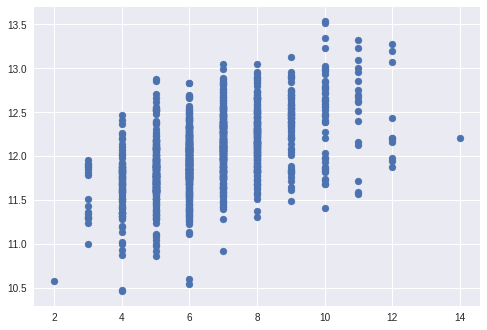

In [554]:
plt.scatter(df.TotRmsAbvGrd, np.log(df.SalePrice))

In [561]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

features = ['LotArea','OverallQual', 'OverallCond', 'GrLivArea','GarageArea', 'FullBath', 'HalfBath', 'fullhalfbath_interaction', 'BedroomAbvGr',
            'sold_pre_2008', 'age_sold','age_sold_squared', 'years_since_remod', 'age_remod_interaction', '1stFlrSF', '2ndFlrSF', 'floor_interaction', 'mszoning_RL', 'mszoning_c',
            'mszoning_RM', 'mszoning_FV', 'good_area', 'bad_area', 'one_fam_home', 'townhouse', 'miscfeature_isnone', 'has_shed', 'new_home', 'attached_garage',
            'detchd_garage', 'lotarea_squared', 'overallqual_squared', 'overallcond_squared', 'is_start_of_school', 'is_spring', 'remodeled?', 'age_remodeled_interaction_good',
            'sq_footage_fsb', 'sqfootage_fsb_squared', 'grlivarea_squared', 'heating_qual_ex', 'heating_qual_pr', 'heating_qual_fa', 'finished_bsmt', 'pos1_feedr_art', 'pos2_feedr_art',
            'pos1_pos2_sum1', 'pos1_pos2_sum2', 'kitchen_numeric_squared', 'garage_cars_squared', 'atypical_function', 'exterior_exc', 'salecond_abnorml', 'no_fireplace', 'lotfrontage_squared',
            'garagearea_squared', 'sq_footage_fsbg', 'banked_land', 'HLS_land', 'salecond_family', 'paved_drive_numeric', 'paved_drive_squared', 'OpenPorchSF', 'WoodDeckSF', 'EnclosedPorch',
            'ScreenPorch', 'garageQual_numeric_squared', 'garage_unf', 'garage_Fin', 'no_central_air', 'Foundation__CBlock', 'Foundation__PConc', 'Foundation__Slab', 'Foundation__Stone', 'Foundation__Wood',
            'RoofStyle_Hip', 'RoofStyle_Gambrel', 'RoofMatl_Wd','TotRmsAbvGrd_squared']

X = df[features].values
y = df.logprice

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


lr = LinearRegression()
lr.fit(X_train, y_train)


oos_pred = lr.predict(X_test)
oos_mse = mean_squared_error(y_test, oos_pred)
oos_r2 = r2_score(y_test, oos_pred)
rmse = (np.sqrt(oos_mse))
rmse, oos_r2

(0.11354183982841168, 0.9255498184141017)

In [0]:
df['TotRmsAbvGrd_squared'] = df.TotRmsAbvGrd ** 2

In [0]:
df['LowQualFinSF_squared'] = df.LowQualFinSF ** 2

In [566]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

features = ['LotArea','OverallQual', 'OverallCond', 'GrLivArea','GarageArea', 'FullBath', 'HalfBath', 'fullhalfbath_interaction', 'BedroomAbvGr',
            'sold_pre_2008', 'age_sold','age_sold_squared', 'years_since_remod', 'age_remod_interaction', '1stFlrSF', '2ndFlrSF', 'floor_interaction', 'mszoning_RL', 'mszoning_c',
            'mszoning_RM', 'mszoning_FV', 'good_area', 'bad_area', 'one_fam_home', 'townhouse', 'miscfeature_isnone', 'has_shed', 'new_home', 'attached_garage',
            'detchd_garage', 'lotarea_squared', 'overallqual_squared', 'overallcond_squared', 'is_start_of_school', 'is_spring', 'remodeled?', 'age_remodeled_interaction_good',
            'sq_footage_fsb', 'sqfootage_fsb_squared', 'grlivarea_squared', 'heating_qual_ex', 'heating_qual_pr', 'heating_qual_fa', 'finished_bsmt', 'pos1_feedr_art', 'pos2_feedr_art',
            'pos1_pos2_sum1', 'pos1_pos2_sum2', 'kitchen_numeric_squared', 'garage_cars_squared', 'atypical_function', 'exterior_exc', 'salecond_abnorml', 'no_fireplace', 'lotfrontage_squared',
            'garagearea_squared', 'sq_footage_fsbg', 'banked_land', 'HLS_land', 'salecond_family', 'paved_drive_numeric', 'paved_drive_squared', 'OpenPorchSF', 'WoodDeckSF', 'EnclosedPorch',
            'ScreenPorch', 'garageQual_numeric_squared', 'garage_unf', 'garage_Fin', 'no_central_air', 'Foundation__CBlock', 'Foundation__PConc', 'Foundation__Slab', 'Foundation__Stone', 'Foundation__Wood',
            'RoofStyle_Hip', 'RoofStyle_Gambrel', 'RoofMatl_Wd','TotRmsAbvGrd_squared', 'LowQualFinSF', 'LowQualFinSF_squared']

X = df[features].values
y = df.logprice

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


lr = LinearRegression()
lr.fit(X_train, y_train)


oos_pred = lr.predict(X_test)
oos_mse = mean_squared_error(y_test, oos_pred)
oos_r2 = r2_score(y_test, oos_pred)
rmse = (np.sqrt(oos_mse))
rmse, oos_r2

(0.1134658534023001, 0.9256494347357169)

In [0]:
df['LowQualFinSF_as_pct_fsb'] = df.LowQualFinSF / df.sq_footage_fsb

In [569]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

features = ['LotArea','OverallQual', 'OverallCond', 'GrLivArea','GarageArea', 'FullBath', 'HalfBath', 'fullhalfbath_interaction', 'BedroomAbvGr',
            'sold_pre_2008', 'age_sold','age_sold_squared', 'years_since_remod', 'age_remod_interaction', '1stFlrSF', '2ndFlrSF', 'floor_interaction', 'mszoning_RL', 'mszoning_c',
            'mszoning_RM', 'mszoning_FV', 'good_area', 'bad_area', 'one_fam_home', 'townhouse', 'miscfeature_isnone', 'has_shed', 'new_home', 'attached_garage',
            'detchd_garage', 'lotarea_squared', 'overallqual_squared', 'overallcond_squared', 'is_start_of_school', 'is_spring', 'remodeled?', 'age_remodeled_interaction_good',
            'sq_footage_fsb', 'sqfootage_fsb_squared', 'grlivarea_squared', 'heating_qual_ex', 'heating_qual_pr', 'heating_qual_fa', 'finished_bsmt', 'pos1_feedr_art', 'pos2_feedr_art',
            'pos1_pos2_sum1', 'pos1_pos2_sum2', 'kitchen_numeric_squared', 'garage_cars_squared', 'atypical_function', 'exterior_exc', 'salecond_abnorml', 'no_fireplace', 'lotfrontage_squared',
            'garagearea_squared', 'sq_footage_fsbg', 'banked_land', 'HLS_land', 'salecond_family', 'paved_drive_numeric', 'paved_drive_squared', 'OpenPorchSF', 'WoodDeckSF', 'EnclosedPorch',
            'ScreenPorch', 'garageQual_numeric_squared', 'garage_unf', 'garage_Fin', 'no_central_air', 'Foundation__CBlock', 'Foundation__PConc', 'Foundation__Slab', 'Foundation__Stone', 'Foundation__Wood',
            'RoofStyle_Hip', 'RoofStyle_Gambrel', 'RoofMatl_Wd','TotRmsAbvGrd_squared', 'LowQualFinSF', 'LowQualFinSF_squared']

X = df[features].values
y = df.logprice

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


lr = LinearRegression()
lr.fit(X_train, y_train)


oos_pred = lr.predict(X_test)
oos_mse = mean_squared_error(y_test, oos_pred)
oos_r2 = r2_score(y_test, oos_pred)
rmse = (np.sqrt(oos_mse))
rmse, oos_r2

(0.1134658534023001, 0.9256494347357169)

In [570]:
df.ExterCond.value_counts()

TA    1282
Gd     146
Fa      28
Ex       3
Po       1
Name: ExterCond, dtype: int64

In [571]:
df.pivot_table(index='ExterCond', values='SalePrice')

,SalePrice
ExterCond,
Ex,201333.333333
Fa,102595.142857
Gd,168897.568493
Po,76500.000000
TA,184034.896256


In [0]:
df['ExterCond_Fa'] = (df.ExterCond == 'Fa')
df['ExterCond_Gd'] = (df.ExterCond == 'Gd')

In [576]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

features = ['LotArea','OverallQual', 'OverallCond', 'GrLivArea','GarageArea', 'FullBath', 'HalfBath', 'fullhalfbath_interaction', 'BedroomAbvGr',
            'sold_pre_2008', 'age_sold','age_sold_squared', 'years_since_remod', 'age_remod_interaction', '1stFlrSF', '2ndFlrSF', 'floor_interaction', 'mszoning_RL', 'mszoning_c',
            'mszoning_RM', 'mszoning_FV', 'good_area', 'bad_area', 'one_fam_home', 'townhouse', 'miscfeature_isnone', 'has_shed', 'new_home', 'attached_garage',
            'detchd_garage', 'lotarea_squared', 'overallqual_squared', 'overallcond_squared', 'is_start_of_school', 'is_spring', 'remodeled?', 'age_remodeled_interaction_good',
            'sq_footage_fsb', 'sqfootage_fsb_squared', 'grlivarea_squared', 'heating_qual_ex', 'heating_qual_pr', 'heating_qual_fa', 'finished_bsmt', 'pos1_feedr_art', 'pos2_feedr_art',
            'pos1_pos2_sum1', 'pos1_pos2_sum2', 'kitchen_numeric_squared', 'garage_cars_squared', 'atypical_function', 'exterior_exc', 'salecond_abnorml', 'no_fireplace', 'lotfrontage_squared',
            'garagearea_squared', 'sq_footage_fsbg', 'banked_land', 'HLS_land', 'salecond_family', 'paved_drive_numeric', 'paved_drive_squared', 'OpenPorchSF', 'WoodDeckSF', 'EnclosedPorch',
            'ScreenPorch', 'garageQual_numeric_squared', 'garage_unf', 'garage_Fin', 'no_central_air', 'Foundation__CBlock', 'Foundation__PConc', 'Foundation__Slab', 'Foundation__Stone', 'Foundation__Wood',
            'RoofStyle_Hip', 'RoofStyle_Gambrel', 'RoofMatl_Wd','TotRmsAbvGrd_squared', 'LowQualFinSF', 'LowQualFinSF_squared']

X = df[features].values
y = df.logprice

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


lr = LinearRegression()
lr.fit(X_train, y_train)


oos_pred = lr.predict(X_test)
oos_mse = mean_squared_error(y_test, oos_pred)
oos_r2 = r2_score(y_test, oos_pred)
rmse = (np.sqrt(oos_mse))
rmse, oos_r2

(0.1134658534023001, 0.9256494347357169)

In [578]:
df.ExterQual.value_counts()

TA    906
Gd    488
Ex     52
Fa     14
Name: ExterQual, dtype: int64

In [0]:
df['ExterQual_numeric'] = df.ExterQual.map({'Po':0, 'Fa':1, 'TA':2, 'Gd':3, 'Ex':4})
df['ExterQual_numeric_squared'] = df.ExterQual_numeric ** 2

In [586]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

features = ['LotArea','OverallQual', 'OverallCond', 'GrLivArea','GarageArea', 'FullBath', 'HalfBath', 'fullhalfbath_interaction', 'BedroomAbvGr',
            'sold_pre_2008', 'age_sold','age_sold_squared', 'years_since_remod', 'age_remod_interaction', '1stFlrSF', '2ndFlrSF', 'floor_interaction', 'mszoning_RL', 'mszoning_c',
            'mszoning_RM', 'mszoning_FV', 'good_area', 'bad_area', 'one_fam_home', 'townhouse', 'miscfeature_isnone', 'has_shed', 'new_home', 'attached_garage',
            'detchd_garage', 'lotarea_squared', 'overallqual_squared', 'overallcond_squared', 'is_start_of_school', 'is_spring', 'remodeled?', 'age_remodeled_interaction_good',
            'sq_footage_fsb', 'sqfootage_fsb_squared', 'grlivarea_squared', 'heating_qual_ex', 'heating_qual_pr', 'heating_qual_fa', 'finished_bsmt', 'pos1_feedr_art', 'pos2_feedr_art',
            'pos1_pos2_sum1', 'pos1_pos2_sum2', 'kitchen_numeric_squared', 'garage_cars_squared', 'atypical_function', 'exterior_exc', 'salecond_abnorml', 'no_fireplace', 'lotfrontage_squared',
            'garagearea_squared', 'sq_footage_fsbg', 'banked_land', 'HLS_land', 'salecond_family', 'paved_drive_numeric', 'paved_drive_squared', 'OpenPorchSF', 'WoodDeckSF', 'EnclosedPorch',
            'ScreenPorch', 'garageQual_numeric_squared', 'garage_unf', 'garage_Fin', 'no_central_air', 'Foundation__CBlock', 'Foundation__PConc', 'Foundation__Slab', 'Foundation__Stone', 'Foundation__Wood',
            'RoofStyle_Hip', 'RoofStyle_Gambrel', 'RoofMatl_Wd','TotRmsAbvGrd_squared', 'LowQualFinSF', 'LowQualFinSF_squared']

X = df[features].values
y = df.logprice

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


lr = LinearRegression()
lr.fit(X_train, y_train)


oos_pred = lr.predict(X_test)
oos_mse = mean_squared_error(y_test, oos_pred)
oos_r2 = r2_score(y_test, oos_pred)
rmse = (np.sqrt(oos_mse))
rmse, oos_r2

(0.1134658534023001, 0.9256494347357169)

In [587]:
df.Exterior1st.value_counts()

VinylSd    515
HdBoard    222
MetalSd    220
Wd Sdng    206
Plywood    108
CemntBd     61
BrkFace     50
WdShing     26
Stucco      25
AsbShng     20
BrkComm      2
Stone        2
ImStucc      1
AsphShn      1
CBlock       1
Name: Exterior1st, dtype: int64

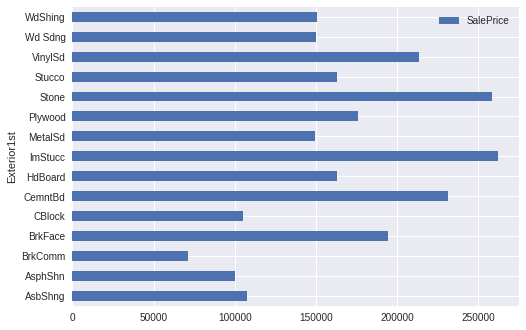

In [589]:
df.pivot_table(index='Exterior1st', values='SalePrice').plot.barh()

In [0]:
df['Exterior1st_VinylSd'] = (df.Exterior1st == 'VinylSd')
df['Exterior1st_MetalSd'] = (df.Exterior1st == 'MetalSd')
df['Exterior1st_WdSdng'] = ((df.Exterior1st == 'Wd Sdng') | (df.Exterior1st == 'WdShing'))
df['Exterior1st_HdBoard'] = (df.Exterior1st == 'HdBoard')
df['Exterior1st_CemntBd'] = (df.Exterior1st == 'CemntBd')
df['Exterior1st_BrkFace'] = (df.Exterior1st == 'BrkFace')
df['Exterior1st_AsbShng'] = (df.Exterior1st == 'AsbShng')


In [612]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

features = ['LotArea','OverallQual', 'OverallCond', 'GrLivArea','GarageArea', 'FullBath', 'HalfBath', 'fullhalfbath_interaction', 'BedroomAbvGr',
            'sold_pre_2008', 'age_sold','age_sold_squared', 'years_since_remod', 'age_remod_interaction', '1stFlrSF', '2ndFlrSF', 'floor_interaction', 'mszoning_RL', 'mszoning_c',
            'mszoning_RM', 'mszoning_FV', 'good_area', 'bad_area', 'one_fam_home', 'townhouse', 'miscfeature_isnone', 'has_shed', 'new_home', 'attached_garage',
            'detchd_garage', 'lotarea_squared', 'overallqual_squared', 'overallcond_squared', 'is_start_of_school', 'is_spring', 'remodeled?', 'age_remodeled_interaction_good',
            'sq_footage_fsb', 'sqfootage_fsb_squared', 'grlivarea_squared', 'heating_qual_ex', 'heating_qual_pr', 'heating_qual_fa', 'finished_bsmt', 'pos1_feedr_art', 'pos2_feedr_art',
            'pos1_pos2_sum1', 'pos1_pos2_sum2', 'kitchen_numeric_squared', 'garage_cars_squared', 'atypical_function', 'exterior_exc', 'salecond_abnorml', 'no_fireplace', 'lotfrontage_squared',
            'garagearea_squared', 'sq_footage_fsbg', 'banked_land', 'HLS_land', 'salecond_family', 'paved_drive_numeric', 'paved_drive_squared', 'OpenPorchSF', 'WoodDeckSF', 'EnclosedPorch',
            'ScreenPorch', 'garageQual_numeric_squared', 'garage_unf', 'garage_Fin', 'no_central_air', 'Foundation__CBlock', 'Foundation__PConc', 'Foundation__Slab', 'Foundation__Stone', 'Foundation__Wood',
            'RoofStyle_Hip', 'RoofStyle_Gambrel', 'RoofMatl_Wd','TotRmsAbvGrd_squared', 'LowQualFinSF', 'LowQualFinSF_squared', 'Exterior1st_VinylSd', 'Exterior1st_MetalSd', 'Exterior1st_WdSdng']

X = df[features].values
y = df.logprice

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


lr = LinearRegression()
lr.fit(X_train, y_train)


oos_pred = lr.predict(X_test)
oos_mse = mean_squared_error(y_test, oos_pred)
oos_r2 = r2_score(y_test, oos_pred)
rmse = (np.sqrt(oos_mse))
rmse, oos_r2

(0.11332212973595311, 0.9258376705395875)

In [613]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

features = ['LotArea','OverallQual', 'OverallCond', 'GrLivArea','GarageArea', 'FullBath', 'HalfBath', 'fullhalfbath_interaction', 'BedroomAbvGr',
            'sold_pre_2008', 'age_sold','age_sold_squared', 'years_since_remod', 'age_remod_interaction', '1stFlrSF', '2ndFlrSF', 'floor_interaction', 'mszoning_RL', 'mszoning_c',
            'mszoning_RM', 'mszoning_FV', 'good_area', 'bad_area', 'one_fam_home', 'townhouse', 'miscfeature_isnone', 'has_shed', 'new_home', 'attached_garage',
            'detchd_garage', 'lotarea_squared', 'overallqual_squared', 'overallcond_squared', 'is_start_of_school', 'is_spring', 'remodeled?', 'age_remodeled_interaction_good',
            'sq_footage_fsb', 'sqfootage_fsb_squared', 'grlivarea_squared', 'heating_qual_ex', 'heating_qual_pr', 'heating_qual_fa', 'finished_bsmt', 'pos1_feedr_art', 'pos2_feedr_art',
            'pos1_pos2_sum1', 'pos1_pos2_sum2', 'kitchen_numeric_squared', 'garage_cars_squared', 'atypical_function', 'exterior_exc', 'salecond_abnorml', 'no_fireplace', 'lotfrontage_squared',
            'garagearea_squared', 'sq_footage_fsbg', 'banked_land', 'HLS_land', 'salecond_family', 'paved_drive_numeric', 'paved_drive_squared', 'OpenPorchSF', 'WoodDeckSF', 'EnclosedPorch',
            'ScreenPorch', 'garageQual_numeric_squared', 'garage_unf', 'garage_Fin', 'no_central_air', 'Foundation__CBlock', 'Foundation__PConc', 'Foundation__Slab', 'Foundation__Stone', 'Foundation__Wood',
            'RoofStyle_Hip', 'RoofStyle_Gambrel', 'RoofMatl_Wd','TotRmsAbvGrd_squared', 'LowQualFinSF', 'LowQualFinSF_squared', 'Exterior1st_VinylSd', 'Exterior1st_MetalSd', 'Exterior1st_WdSdng']

X = df[features].values
y = df.logprice

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


lr = Ridge()
lr.fit(X_train, y_train)


oos_pred = lr.predict(X_test)
oos_mse = mean_squared_error(y_test, oos_pred)
oos_r2 = r2_score(y_test, oos_pred)
rmse = (np.sqrt(oos_mse))
rmse, oos_r2

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.675991e-22
  overwrite_a=True).T


(0.11438186960717796, 0.92444411641912)

In [614]:
df.pivot_table(index='MasVnrType', values='SalePrice')

,SalePrice
MasVnrType,
BrkCmn,146318.066667
BrkFace,204691.871910
None,156221.891204
Stone,265583.625000


In [615]:
df.MasVnrType.value_counts()

None       864
BrkFace    445
Stone      128
BrkCmn      15
Name: MasVnrType, dtype: int64

In [0]:
df['MasVnrType_Stone'] = (df.MasVnrType == 'Stone')
df['MasVnrType_BrkFace'] = (df.MasVnrType == 'BrkFace')
df['MasVnrType_BrkCmn'] = (df.MasVnrType == 'BrkCmn')

In [623]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

features = ['LotArea','OverallQual', 'OverallCond', 'GrLivArea','GarageArea', 'FullBath', 'HalfBath', 'fullhalfbath_interaction', 'BedroomAbvGr',
            'sold_pre_2008', 'age_sold','age_sold_squared', 'years_since_remod', 'age_remod_interaction', '1stFlrSF', '2ndFlrSF', 'floor_interaction', 'mszoning_RL', 'mszoning_c',
            'mszoning_RM', 'mszoning_FV', 'good_area', 'bad_area', 'one_fam_home', 'townhouse', 'miscfeature_isnone', 'has_shed', 'new_home', 'attached_garage',
            'detchd_garage', 'lotarea_squared', 'overallqual_squared', 'overallcond_squared', 'is_start_of_school', 'is_spring', 'remodeled?', 'age_remodeled_interaction_good',
            'sq_footage_fsb', 'sqfootage_fsb_squared', 'grlivarea_squared', 'heating_qual_ex', 'heating_qual_pr', 'heating_qual_fa', 'finished_bsmt', 'pos1_feedr_art', 'pos2_feedr_art',
            'pos1_pos2_sum1', 'pos1_pos2_sum2', 'kitchen_numeric_squared', 'garage_cars_squared', 'atypical_function', 'exterior_exc', 'salecond_abnorml', 'no_fireplace', 'lotfrontage_squared',
            'garagearea_squared', 'sq_footage_fsbg', 'banked_land', 'HLS_land', 'salecond_family', 'paved_drive_numeric', 'paved_drive_squared', 'OpenPorchSF', 'WoodDeckSF', 'EnclosedPorch',
            'ScreenPorch', 'garageQual_numeric_squared', 'garage_unf', 'garage_Fin', 'no_central_air', 'Foundation__CBlock', 'Foundation__PConc', 'Foundation__Slab', 'Foundation__Stone', 'Foundation__Wood',
            'RoofStyle_Hip', 'RoofStyle_Gambrel', 'RoofMatl_Wd','TotRmsAbvGrd_squared', 'LowQualFinSF', 'LowQualFinSF_squared', 'Exterior1st_VinylSd', 'Exterior1st_MetalSd', 'Exterior1st_WdSdng', 'MasVnrType_Stone',
            'MasVnrType_BrkCmn']

X = df[features].values
y = df.logprice

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


lr = LinearRegression()
lr.fit(X_train, y_train)


oos_pred = lr.predict(X_test)
oos_mse = mean_squared_error(y_test, oos_pred)
oos_r2 = r2_score(y_test, oos_pred)
rmse = (np.sqrt(oos_mse))
rmse, oos_r2

(0.11298004099825668, 0.9262847465875031)

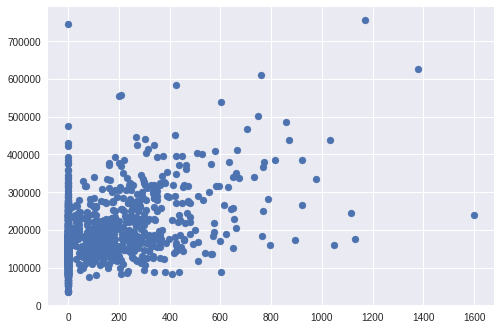

In [624]:
plt.scatter(df.MasVnrArea, df.SalePrice)

In [625]:
df.shape[0]

1460

In [627]:
df[df.MasVnrArea > 0].SalePrice.mean()

215662.74111675128

In [0]:
df['has_MasVnr'] = (df.MasVnrArea > 0)

In [631]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

features = ['LotArea','OverallQual', 'OverallCond', 'GrLivArea','GarageArea', 'FullBath', 'HalfBath', 'fullhalfbath_interaction', 'BedroomAbvGr',
            'sold_pre_2008', 'age_sold','age_sold_squared', 'years_since_remod', 'age_remod_interaction', '1stFlrSF', '2ndFlrSF', 'floor_interaction', 'mszoning_RL', 'mszoning_c',
            'mszoning_RM', 'mszoning_FV', 'good_area', 'bad_area', 'one_fam_home', 'townhouse', 'miscfeature_isnone', 'has_shed', 'new_home', 'attached_garage',
            'detchd_garage', 'lotarea_squared', 'overallqual_squared', 'overallcond_squared', 'is_start_of_school', 'is_spring', 'remodeled?', 'age_remodeled_interaction_good',
            'sq_footage_fsb', 'sqfootage_fsb_squared', 'grlivarea_squared', 'heating_qual_ex', 'heating_qual_pr', 'heating_qual_fa', 'finished_bsmt', 'pos1_feedr_art', 'pos2_feedr_art',
            'pos1_pos2_sum1', 'pos1_pos2_sum2', 'kitchen_numeric_squared', 'garage_cars_squared', 'atypical_function', 'exterior_exc', 'salecond_abnorml', 'no_fireplace', 'lotfrontage_squared',
            'garagearea_squared', 'sq_footage_fsbg', 'banked_land', 'HLS_land', 'salecond_family', 'paved_drive_numeric', 'paved_drive_squared', 'OpenPorchSF', 'WoodDeckSF', 'EnclosedPorch',
            'ScreenPorch', 'garageQual_numeric_squared', 'garage_unf', 'garage_Fin', 'no_central_air', 'Foundation__CBlock', 'Foundation__PConc', 'Foundation__Slab', 'Foundation__Stone', 'Foundation__Wood',
            'RoofStyle_Hip', 'RoofStyle_Gambrel', 'RoofMatl_Wd','TotRmsAbvGrd_squared', 'LowQualFinSF', 'LowQualFinSF_squared', 'Exterior1st_VinylSd', 'Exterior1st_MetalSd', 'Exterior1st_WdSdng', 'MasVnrType_Stone',
            'MasVnrType_BrkCmn']

X = df[features].values
y = df.logprice

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


lr = LinearRegression()
lr.fit(X_train, y_train)


oos_pred = lr.predict(X_test)
oos_mse = mean_squared_error(y_test, oos_pred)
oos_r2 = r2_score(y_test, oos_pred)
rmse = (np.sqrt(oos_mse))
rmse, oos_r2

(0.11298004099825668, 0.9262847465875031)

In [634]:
df.MasVnrArea.isna().sum()

8

In [0]:
df.MasVnrArea = df.MasVnrArea.fillna(0)

In [0]:
df['MasVnrArea_squared'] = df.MasVnrArea ** 2

In [641]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

features = ['LotArea','OverallQual', 'OverallCond', 'GrLivArea','GarageArea', 'FullBath', 'HalfBath', 'fullhalfbath_interaction', 'BedroomAbvGr',
            'sold_pre_2008', 'age_sold','age_sold_squared', 'years_since_remod', 'age_remod_interaction', '1stFlrSF', '2ndFlrSF', 'floor_interaction', 'mszoning_RL', 'mszoning_c',
            'mszoning_RM', 'mszoning_FV', 'good_area', 'bad_area', 'one_fam_home', 'townhouse', 'miscfeature_isnone', 'has_shed', 'new_home', 'attached_garage',
            'detchd_garage', 'lotarea_squared', 'overallqual_squared', 'overallcond_squared', 'is_start_of_school', 'is_spring', 'remodeled?', 'age_remodeled_interaction_good',
            'sq_footage_fsb', 'sqfootage_fsb_squared', 'grlivarea_squared', 'heating_qual_ex', 'heating_qual_pr', 'heating_qual_fa', 'finished_bsmt', 'pos1_feedr_art', 'pos2_feedr_art',
            'pos1_pos2_sum1', 'pos1_pos2_sum2', 'kitchen_numeric_squared', 'garage_cars_squared', 'atypical_function', 'exterior_exc', 'salecond_abnorml', 'no_fireplace', 'lotfrontage_squared',
            'garagearea_squared', 'sq_footage_fsbg', 'banked_land', 'HLS_land', 'salecond_family', 'paved_drive_numeric', 'paved_drive_squared', 'OpenPorchSF', 'WoodDeckSF', 'EnclosedPorch',
            'ScreenPorch', 'garageQual_numeric_squared', 'garage_unf', 'garage_Fin', 'no_central_air', 'Foundation__CBlock', 'Foundation__PConc', 'Foundation__Slab', 'Foundation__Stone', 'Foundation__Wood',
            'RoofStyle_Hip', 'RoofStyle_Gambrel', 'RoofMatl_Wd','TotRmsAbvGrd_squared', 'LowQualFinSF', 'LowQualFinSF_squared', 'Exterior1st_VinylSd', 'Exterior1st_MetalSd', 'Exterior1st_WdSdng', 'MasVnrType_Stone',
            'MasVnrType_BrkCmn']

X = df[features].values
y = df.logprice

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


lr = LinearRegression()
lr.fit(X_train, y_train)


oos_pred = lr.predict(X_test)
oos_mse = mean_squared_error(y_test, oos_pred)
oos_r2 = r2_score(y_test, oos_pred)
rmse = (np.sqrt(oos_mse))
rmse, oos_r2

(0.11298004099825668, 0.9262847465875031)

In [0]:
df['street_grvl'] = (df.Street == 'Grvl')

In [647]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

features = ['LotArea','OverallQual', 'OverallCond', 'GrLivArea','GarageArea', 'FullBath', 'HalfBath', 'fullhalfbath_interaction', 'BedroomAbvGr',
            'sold_pre_2008', 'age_sold','age_sold_squared', 'years_since_remod', 'age_remod_interaction', '1stFlrSF', '2ndFlrSF', 'floor_interaction', 'mszoning_RL', 'mszoning_c',
            'mszoning_RM', 'mszoning_FV', 'good_area', 'bad_area', 'one_fam_home', 'townhouse', 'miscfeature_isnone', 'has_shed', 'new_home', 'attached_garage',
            'detchd_garage', 'lotarea_squared', 'overallqual_squared', 'overallcond_squared', 'is_start_of_school', 'is_spring', 'remodeled?', 'age_remodeled_interaction_good',
            'sq_footage_fsb', 'sqfootage_fsb_squared', 'grlivarea_squared', 'heating_qual_ex', 'heating_qual_pr', 'heating_qual_fa', 'finished_bsmt', 'pos1_feedr_art', 'pos2_feedr_art',
            'pos1_pos2_sum1', 'pos1_pos2_sum2', 'kitchen_numeric_squared', 'garage_cars_squared', 'atypical_function', 'exterior_exc', 'salecond_abnorml', 'no_fireplace', 'lotfrontage_squared',
            'garagearea_squared', 'sq_footage_fsbg', 'banked_land', 'HLS_land', 'salecond_family', 'paved_drive_numeric', 'paved_drive_squared', 'OpenPorchSF', 'WoodDeckSF', 'EnclosedPorch',
            'ScreenPorch', 'garageQual_numeric_squared', 'garage_unf', 'garage_Fin', 'no_central_air', 'Foundation__CBlock', 'Foundation__PConc', 'Foundation__Slab', 'Foundation__Stone', 'Foundation__Wood',
            'RoofStyle_Hip', 'RoofStyle_Gambrel', 'RoofMatl_Wd','TotRmsAbvGrd_squared', 'LowQualFinSF', 'LowQualFinSF_squared', 'Exterior1st_VinylSd', 'Exterior1st_MetalSd', 'Exterior1st_WdSdng', 'MasVnrType_Stone',
            'MasVnrType_BrkCmn', 'street_grvl']

X = df[features].values
y = df.logprice

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


lr = LinearRegression()
lr.fit(X_train, y_train)


oos_pred = lr.predict(X_test)
oos_mse = mean_squared_error(y_test, oos_pred)
oos_r2 = r2_score(y_test, oos_pred)
rmse = (np.sqrt(oos_mse))
rmse, oos_r2

(0.11296985700926777, 0.9262980353328036)

In [649]:
df[df.Neighborhood == 'Crawfor'].SalePrice.mean()

210624.72549019608

In [0]:
df['Neighborhood_Crawfor'] = (df.Neighborhood == 'Crawfor')

In [651]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

features = ['LotArea','OverallQual', 'OverallCond', 'GrLivArea','GarageArea', 'FullBath', 'HalfBath', 'fullhalfbath_interaction', 'BedroomAbvGr',
            'sold_pre_2008', 'age_sold','age_sold_squared', 'years_since_remod', 'age_remod_interaction', '1stFlrSF', '2ndFlrSF', 'floor_interaction', 'mszoning_RL', 'mszoning_c',
            'mszoning_RM', 'mszoning_FV', 'good_area', 'bad_area', 'one_fam_home', 'townhouse', 'miscfeature_isnone', 'has_shed', 'new_home', 'attached_garage',
            'detchd_garage', 'lotarea_squared', 'overallqual_squared', 'overallcond_squared', 'is_start_of_school', 'is_spring', 'remodeled?', 'age_remodeled_interaction_good',
            'sq_footage_fsb', 'sqfootage_fsb_squared', 'grlivarea_squared', 'heating_qual_ex', 'heating_qual_pr', 'heating_qual_fa', 'finished_bsmt', 'pos1_feedr_art', 'pos2_feedr_art',
            'pos1_pos2_sum1', 'pos1_pos2_sum2', 'kitchen_numeric_squared', 'garage_cars_squared', 'atypical_function', 'exterior_exc', 'salecond_abnorml', 'no_fireplace', 'lotfrontage_squared',
            'garagearea_squared', 'sq_footage_fsbg', 'banked_land', 'HLS_land', 'salecond_family', 'paved_drive_numeric', 'paved_drive_squared', 'OpenPorchSF', 'WoodDeckSF', 'EnclosedPorch',
            'ScreenPorch', 'garageQual_numeric_squared', 'garage_unf', 'garage_Fin', 'no_central_air', 'Foundation__CBlock', 'Foundation__PConc', 'Foundation__Slab', 'Foundation__Stone', 'Foundation__Wood',
            'RoofStyle_Hip', 'RoofStyle_Gambrel', 'RoofMatl_Wd','TotRmsAbvGrd_squared', 'LowQualFinSF', 'LowQualFinSF_squared', 'Exterior1st_VinylSd', 'Exterior1st_MetalSd', 'Exterior1st_WdSdng', 'MasVnrType_Stone',
            'MasVnrType_BrkCmn', 'street_grvl', 'Neighborhood_Crawfor']

X = df[features].values
y = df.logprice

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


lr = LinearRegression()
lr.fit(X_train, y_train)


oos_pred = lr.predict(X_test)
oos_mse = mean_squared_error(y_test, oos_pred)
oos_r2 = r2_score(y_test, oos_pred)
rmse = (np.sqrt(oos_mse))
rmse, oos_r2

(0.11017698535576208, 0.9298971495635044)

In [0]:
df['Neighborhood_Crawfor'] = (df.Neighborhood == 'Crawfor')
df['Neighborhood_2'] = df.Neighborhood
df = pd.get_dummies(df, prefix='Neighborhood', columns=['Neighborhood_2'])

features = ['LotArea','OverallQual', 'OverallCond', 'GrLivArea','GarageArea', 'FullBath', 'HalfBath', 'fullhalfbath_interaction', 'BedroomAbvGr',
            'sold_pre_2008', 'age_sold','age_sold_squared', 'years_since_remod', 'age_remod_interaction', '1stFlrSF', '2ndFlrSF', 'floor_interaction', 'mszoning_RL', 'mszoning_c',
            'mszoning_RM', 'mszoning_FV', 'good_area', 'bad_area', 'one_fam_home', 'townhouse', 'miscfeature_isnone', 'has_shed', 'new_home', 'attached_garage',
            'detchd_garage', 'lotarea_squared', 'overallqual_squared', 'overallcond_squared', 'is_start_of_school', 'is_spring', 'remodeled?', 'age_remodeled_interaction_good',
            'sq_footage_fsb', 'sqfootage_fsb_squared', 'grlivarea_squared', 'heating_qual_ex', 'heating_qual_pr', 'heating_qual_fa', 'finished_bsmt', 'pos1_feedr_art', 'pos2_feedr_art',
            'pos1_pos2_sum1', 'pos1_pos2_sum2', 'kitchen_numeric_squared', 'garage_cars_squared', 'atypical_function', 'exterior_exc', 'salecond_abnorml', 'no_fireplace', 'lotfrontage_squared',
            'garagearea_squared', 'sq_footage_fsbg', 'banked_land', 'HLS_land', 'salecond_family', 'paved_drive_numeric', 'paved_drive_squared', 'OpenPorchSF', 'WoodDeckSF', 'EnclosedPorch',
            'ScreenPorch', 'garageQual_numeric_squared', 'garage_unf', 'garage_Fin', 'no_central_air', 'Foundation__CBlock', 'Foundation__PConc', 'Foundation__Slab', 'Foundation__Stone', 'Foundation__Wood',
            'RoofStyle_Hip', 'RoofStyle_Gambrel', 'RoofMatl_Wd','TotRmsAbvGrd_squared', 'LowQualFinSF', 'LowQualFinSF_squared', 'Exterior1st_VinylSd', 'Exterior1st_MetalSd', 'Exterior1st_WdSdng', 'MasVnrType_Stone',
            'MasVnrType_BrkCmn', 'street_grvl', 'Neighborhood_Crawfor']

for n in list(df.Neighborhood.unique()):
  if ('Neighborhood_' + n) not in features:
    features.append('Neighborhood_' + n)



In [657]:
df.Neighborhood_2.unique()

array(['CollgCr', 'Veenker', 'Crawfor', 'NoRidge', 'Mitchel', 'Somerst',
       'NWAmes', 'OldTown', 'BrkSide', 'Sawyer', 'NridgHt', 'NAmes',
       'SawyerW', 'IDOTRR', 'MeadowV', 'Edwards', 'Timber', 'Gilbert',
       'StoneBr', 'ClearCr', 'NPkVill', 'Blmngtn', 'BrDale', 'SWISU',
       'Blueste'], dtype=object)

In [661]:
len(features)

112

In [662]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

X = df[features].values
y = df.logprice

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


lr = LinearRegression()
lr.fit(X_train, y_train)


oos_pred = lr.predict(X_test)
oos_mse = mean_squared_error(y_test, oos_pred)
oos_r2 = r2_score(y_test, oos_pred)
rmse = (np.sqrt(oos_mse))
rmse, oos_r2

(0.10949566101942906, 0.9307614879293321)

In [665]:
df.Neighborhood.value_counts()

NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     41
Timber      38
IDOTRR      37
ClearCr     28
StoneBr     25
SWISU       25
MeadowV     17
Blmngtn     17
BrDale      16
Veenker     11
NPkVill      9
Blueste      2
Name: Neighborhood, dtype: int64

In [667]:
len(features)

112

In [0]:
features.remove('good_area')
features.remove('bad_area')

In [737]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

X = df[features].values
y = df.logprice

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


lr = LinearRegression()
lr.fit(X_train, y_train)


oos_pred = lr.predict(X_test)
oos_mse = mean_squared_error(y_test, oos_pred)
oos_r2 = r2_score(y_test, oos_pred)
rmse = (np.sqrt(oos_mse))
rmse, oos_r2

(0.10949566357787381, 0.9307614846937169)

In [739]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

X = df[features].values
y = df.logprice

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

lr = Ridge()
lr.fit(X_train, y_train)


oos_pred = lr.predict(X_test)
oos_mse = mean_squared_error(y_test, oos_pred)
oos_r2 = r2_score(y_test, oos_pred)
rmse = (np.sqrt(oos_mse))
rmse, oos_r2

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.421563e-22
  overwrite_a=True).T


(0.10999837466209683, 0.9301242563327278)

In [741]:
df.LotConfig.value_counts()

Inside     1052
Corner      263
CulDSac      94
FR2          47
FR3           4
Name: LotConfig, dtype: int64

In [0]:
df['LotConfig_Culdasac'] = (df.LotConfig == 'CullDSac')
features.append('LotConfig_Culdasac')

In [0]:
features.append('LotConfig_Culdasac')

In [747]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

X = df[features].values
y = df.logprice

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


lr = LinearRegression()
lr.fit(X_train, y_train)


oos_pred = lr.predict(X_test)
oos_mse = mean_squared_error(y_test, oos_pred)
oos_r2 = r2_score(y_test, oos_pred)
rmse = (np.sqrt(oos_mse))
rmse, oos_r2

(0.10949566357464978, 0.9307614846977943)

In [0]:
from sklearn.linear_model import LogisticRegression

